# Credit Risk Modeling and RAG-Enhanced Explainable Decision Support System

## 1. Introduction

This notebook develops a credit risk Probability of Default (PD) model using public LendingClub loan data. Logistic regression is used as a baseline model and compared with tree-based methods such as XGBoost. Model performance is evaluated using AUC-ROC and KS statistics, and SHAP is applied to explain key risk drivers. The objective is to support human credit assessment through transparent and interpretable modeling.

## 2. Problem Definition & Target Variable

The objective of this analysis is to predict loan default using historical LendingClub data. From a credit risk perspective, default represents a failure of the borrower to meet contractual repayment obligations.

Default is defined as loans with a status of **Charged Off** or **Default**, while loans that are **Fully Paid** are treated as non-default. Loans with ongoing or incomplete statuses are excluded to ensure a well-defined supervised learning problem, as their final repayment outcomes are not yet observed.

This target definition is consistent with standard industry practice for Probability of Default (PD) modeling, where only resolved loans are used for model training and evaluation.

## 3. Data Description


The dataset used in this analysis is sourced from **LendingClub**, a peer-to-peer lending platform based in the United States. It contains loan-level information for loans issued between 2007 and 2015, including borrower financial characteristics, credit history indicators, loan attributes, and repayment outcomes.

The original dataset is large in scale and **includes hundreds of thousands of observations and numerous variables. For the purpose of credit risk modeling, a subset of economically meaningful features is selected, focusing on borrower repayment capacity, credit behavior, utilization, and loan characteristics. This approach reflects common industry practice and helps ensure efficient and interpretable model development.

## 4. Data Preparation

The data preparation process focuses on **creating a clean and modeling-ready dataset** for credit risk analysis. Only loans with resolved outcomes are retained, where Charged Off and Default loans are treated as default events and Fully Paid loans as non-default. Loans with ongoing or incomplete statuses are excluded to avoid label ambiguity.

In [57]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import re
import math
import matplotlib.ticker as mtick
from scipy.stats import ks_2samp

from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import roc_curve, auc, roc_auc_score,recall_score,precision_score,f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score,precision_recall_curve

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import shap

from llama_index.core import (
    SimpleDirectoryReader,
    VectorStoreIndex,
    Settings
)
from llama_index.readers.file import PDFReader
from llama_index.core.node_parser import SentenceSplitter
from llama_index.embeddings.openai import OpenAIEmbedding

import warnings
import logging
for m in ["sklearn", "shap", "matplotlib"]:
    warnings.filterwarnings("ignore", module=m)

logging.getLogger("matplotlib").setLevel(logging.ERROR)

import joblib

In [58]:
pd.options.display.max_columns = None

In [59]:
status= pd.read_excel(r"C:\Users\USER\Desktop\data set\lending club data set\LCDataDictionary.xlsx")
status.head(135)

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by the borrower during registration.
...,...,...
130,hardship_reason,Describes the reason the hardship plan was offered
131,hardship_status,"Describes if the hardship plan is active, pending, canceled, completed, or broken"
132,deferral_term,Amount of months that the borrower is expected to pay less than the contractual monthly payment amount due to a hardship plan
133,hardship_amount,The interest payment that the borrower has committed to make each month while they are on a hardship plan


In [60]:
use_cols = [
    # target
    "loan_status",

    # borrower capacity
    "annual_inc", "dti", "installment", "emp_length",
    "home_ownership", "application_type",

    # credit history (fico proxies)
    "earliest_cr_line", "delinq_2yrs", "acc_now_delinq",
    "mths_since_last_delinq", "num_accts_ever_120_pd",
    "pub_rec", "pub_rec_bankruptcies", "tax_liens",

    # utilization & balances
    "revol_util", "all_util", "bc_util", "revol_bal",
    "total_bal_ex_mort", "total_rev_hi_lim", "avg_cur_bal",

    # credit activity
    "inq_last_6mths", "inq_last_12m",
    "acc_open_past_24mths", "open_acc_6m",
    "num_tl_op_past_12m",

    # loan characteristics
    "loan_amnt", "term", "int_rate", "purpose",

    # verification
    "verification_status"
]

loan = pd.read_csv(r"C:\Users\USER\Desktop\data set\lending club data set\loan.csv", usecols=use_cols,
    low_memory=False)
loan.head()

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,pub_rec,revol_bal,revol_util,application_type,acc_now_delinq,open_acc_6m,all_util,total_rev_hi_lim,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_util,num_accts_ever_120_pd,num_tl_op_past_12m,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort
0,2500,36 months,13.56,84.92,10+ years,RENT,55000.0,Not Verified,Current,debt_consolidation,18.24,0.0,Apr-2001,1.0,NaN,1.0,4341,10.3,Individual,0.0,2.0,28.0,42000.0,2.0,9.0,1878.0,5.9,0.0,3.0,1.0,0.0,16901.0
1,30000,60 months,18.94,777.23,10+ years,MORTGAGE,90000.0,Source Verified,Current,debt_consolidation,26.52,0.0,Jun-1987,0.0,71.0,1.0,12315,24.2,Individual,0.0,4.0,57.0,50800.0,2.0,10.0,24763.0,8.3,0.0,6.0,1.0,0.0,99468.0
2,5000,36 months,17.97,180.69,6 years,MORTGAGE,59280.0,Source Verified,Current,debt_consolidation,10.51,0.0,Apr-2011,0.0,NaN,0.0,4599,19.1,Individual,0.0,0.0,35.0,24100.0,0.0,4.0,18383.0,0.0,0.0,0.0,0.0,0.0,11749.0
3,4000,36 months,18.94,146.51,10+ years,MORTGAGE,92000.0,Source Verified,Current,debt_consolidation,16.74,0.0,Feb-2006,0.0,NaN,0.0,5468,78.1,Individual,0.0,1.0,70.0,7000.0,3.0,5.0,30505.0,75.2,0.0,3.0,0.0,0.0,36151.0
4,30000,60 months,16.14,731.78,10+ years,MORTGAGE,57250.0,Not Verified,Current,debt_consolidation,26.35,0.0,Dec-2000,0.0,NaN,0.0,829,3.6,Individual,0.0,3.0,54.0,23100.0,0.0,9.0,9667.0,8.9,0.0,5.0,0.0,0.0,29674.0


In [61]:
loan = loan.reset_index(drop= True)
loan['case_id'] = (loan.index+1).astype('str')
loan = loan.set_index('case_id')
loan.head()

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,pub_rec,revol_bal,revol_util,application_type,acc_now_delinq,open_acc_6m,all_util,total_rev_hi_lim,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_util,num_accts_ever_120_pd,num_tl_op_past_12m,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort
case_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2500,36 months,13.56,84.92,10+ years,RENT,55000.0,Not Verified,Current,debt_consolidation,18.24,0.0,Apr-2001,1.0,NaN,1.0,4341,10.3,Individual,0.0,2.0,28.0,42000.0,2.0,9.0,1878.0,5.9,0.0,3.0,1.0,0.0,16901.0
2,30000,60 months,18.94,777.23,10+ years,MORTGAGE,90000.0,Source Verified,Current,debt_consolidation,26.52,0.0,Jun-1987,0.0,71.0,1.0,12315,24.2,Individual,0.0,4.0,57.0,50800.0,2.0,10.0,24763.0,8.3,0.0,6.0,1.0,0.0,99468.0
3,5000,36 months,17.97,180.69,6 years,MORTGAGE,59280.0,Source Verified,Current,debt_consolidation,10.51,0.0,Apr-2011,0.0,NaN,0.0,4599,19.1,Individual,0.0,0.0,35.0,24100.0,0.0,4.0,18383.0,0.0,0.0,0.0,0.0,0.0,11749.0
4,4000,36 months,18.94,146.51,10+ years,MORTGAGE,92000.0,Source Verified,Current,debt_consolidation,16.74,0.0,Feb-2006,0.0,NaN,0.0,5468,78.1,Individual,0.0,1.0,70.0,7000.0,3.0,5.0,30505.0,75.2,0.0,3.0,0.0,0.0,36151.0
5,30000,60 months,16.14,731.78,10+ years,MORTGAGE,57250.0,Not Verified,Current,debt_consolidation,26.35,0.0,Dec-2000,0.0,NaN,0.0,829,3.6,Individual,0.0,3.0,54.0,23100.0,0.0,9.0,9667.0,8.9,0.0,5.0,0.0,0.0,29674.0


### 4.1 Define the default variable

In [62]:
loan['loan_status'].value_counts()

loan_status
Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: count, dtype: int64

In [63]:
# Identify loan staturs
uncertain_status = [
    'Current',
    'In Grace Period',
    'Late (16-30 days)',
    'Late (31-120 days)'
]

default_status = [
    'Charged Off',
    'Default',
    'Does not meet the credit policy. Status:Charged Off'
]

non_default_status = [
    'Fully Paid',
    'Does not meet the credit policy. Status:Fully Paid'
]

# Create a clean loan set excluding uncertain statuses
loan_set = loan[~loan['loan_status'].isin(uncertain_status)].copy() 

# map loan_status to binary values
loan_set['is_default'] = loan_set['loan_status'].map(
    lambda x: 1 if x in default_status else 0
)
loan_set['is_default'].value_counts(normalize=True)

is_default
0    0.799105
1    0.200895
Name: proportion, dtype: float64

This means:
- ~ 79.9% of loans are non-default
- ~ 20.1% of loans defaulted

## 5.Explantory Data Analysis
The exploratory analysis examines key financial, credit behavior, and loan characteristics to understand how they differ between defaulted and non-defaulted loans. This step helps confirm the reasonableness of the constructed target variable and informs subsequent model development.

In [64]:
print(f"The final dataset has {loan_set.shape[0]} rows and {loan_set.shape[1]} columns.")
print("\n")
print("The variable type of the data set is as below:")
print(loan_set.dtypes)

The final dataset has 1306387 rows and 33 columns.


The variable type of the data set is as below:
loan_amnt                   int64
term                       object
int_rate                  float64
installment               float64
emp_length                 object
home_ownership             object
annual_inc                float64
verification_status        object
loan_status                object
purpose                    object
dti                       float64
delinq_2yrs               float64
earliest_cr_line           object
inq_last_6mths            float64
mths_since_last_delinq    float64
pub_rec                   float64
revol_bal                   int64
revol_util                float64
application_type           object
acc_now_delinq            float64
open_acc_6m               float64
all_util                  float64
total_rev_hi_lim          float64
inq_last_12m              float64
acc_open_past_24mths      float64
avg_cur_bal               float64
bc_util         

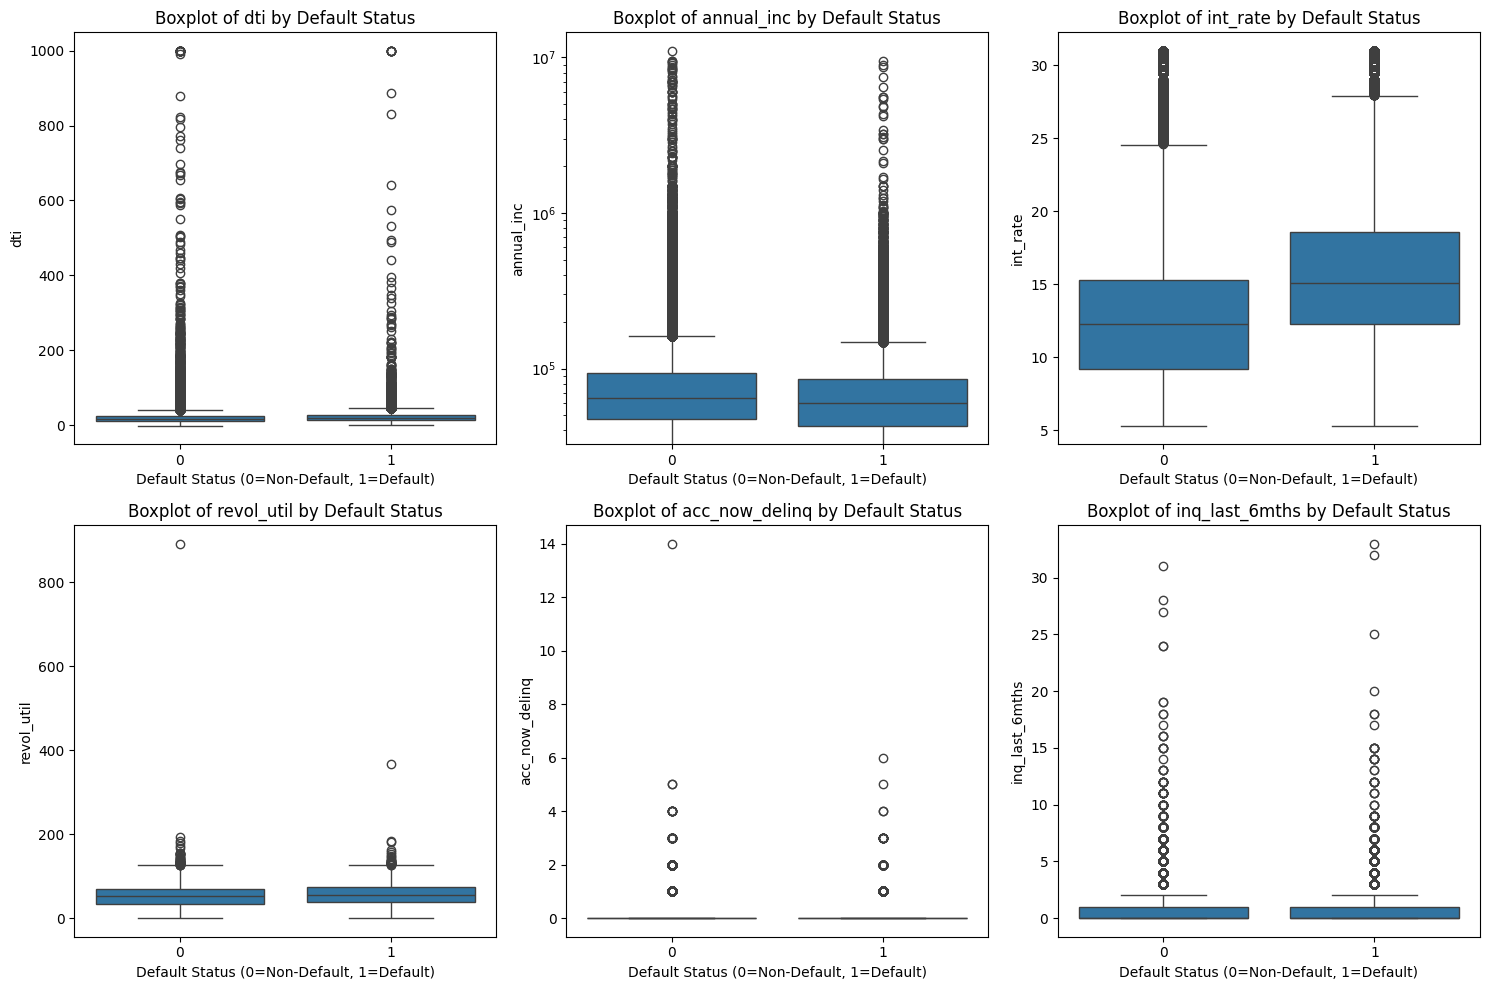

In [65]:
# Create a set for important features for box plots
box_features = ['dti','annual_inc','int_rate','revol_util','acc_now_delinq','inq_last_6mths']

for b in box_features:
    loan_set[b] = pd.to_numeric(loan_set[b], errors='coerce')

loan_set['is_default'] = pd.to_numeric(loan_set['is_default'], errors='coerce')

# Box plots for numerical features by default status
fig,axes = plt.subplots(2,3,figsize=(15,10))
axes = axes.flatten()

for ax,feature in zip(axes, box_features):
    sns.boxplot(x = 'is_default',y=feature,data=loan_set, ax=ax)
    ax.set_title(f'Boxplot of {feature} by Default Status')
    ax.set_xlabel('Default Status (0=Non-Default, 1=Default)')

axes[1].set_yscale('log')
plt.tight_layout()
plt.show()

### Key inference from the EDA boxplots
1. Debt-to-Income Ratio (`dti`)
Hihger debt-to-income ratio is strongly associated with default risk

2. Annual Income(`annual_inc`)
Defaulted borrowers tend to have lower median income. Income distributions are highly skewed (long right tail), which is expected in consumer credit data.

3. Interest Rate (`int_rate`)
Interest rates already reflect ex-ante risk assessment by the lender and are strongly correlated with realized default outcomes.

4. Revolving Credit Utilization (`revol_util`)
High revolving credit utilization is a strong indicator of financial strain and default risk.

5. Current Delinquencies (`acc_now_delinq`)
Any current delinquency is a strong red flag despite being infrequent.

6. Recent Credit Inquiries (`inq_last_6mths`)
Increased recent credit-seeking behavior is associated with elevated default risk.

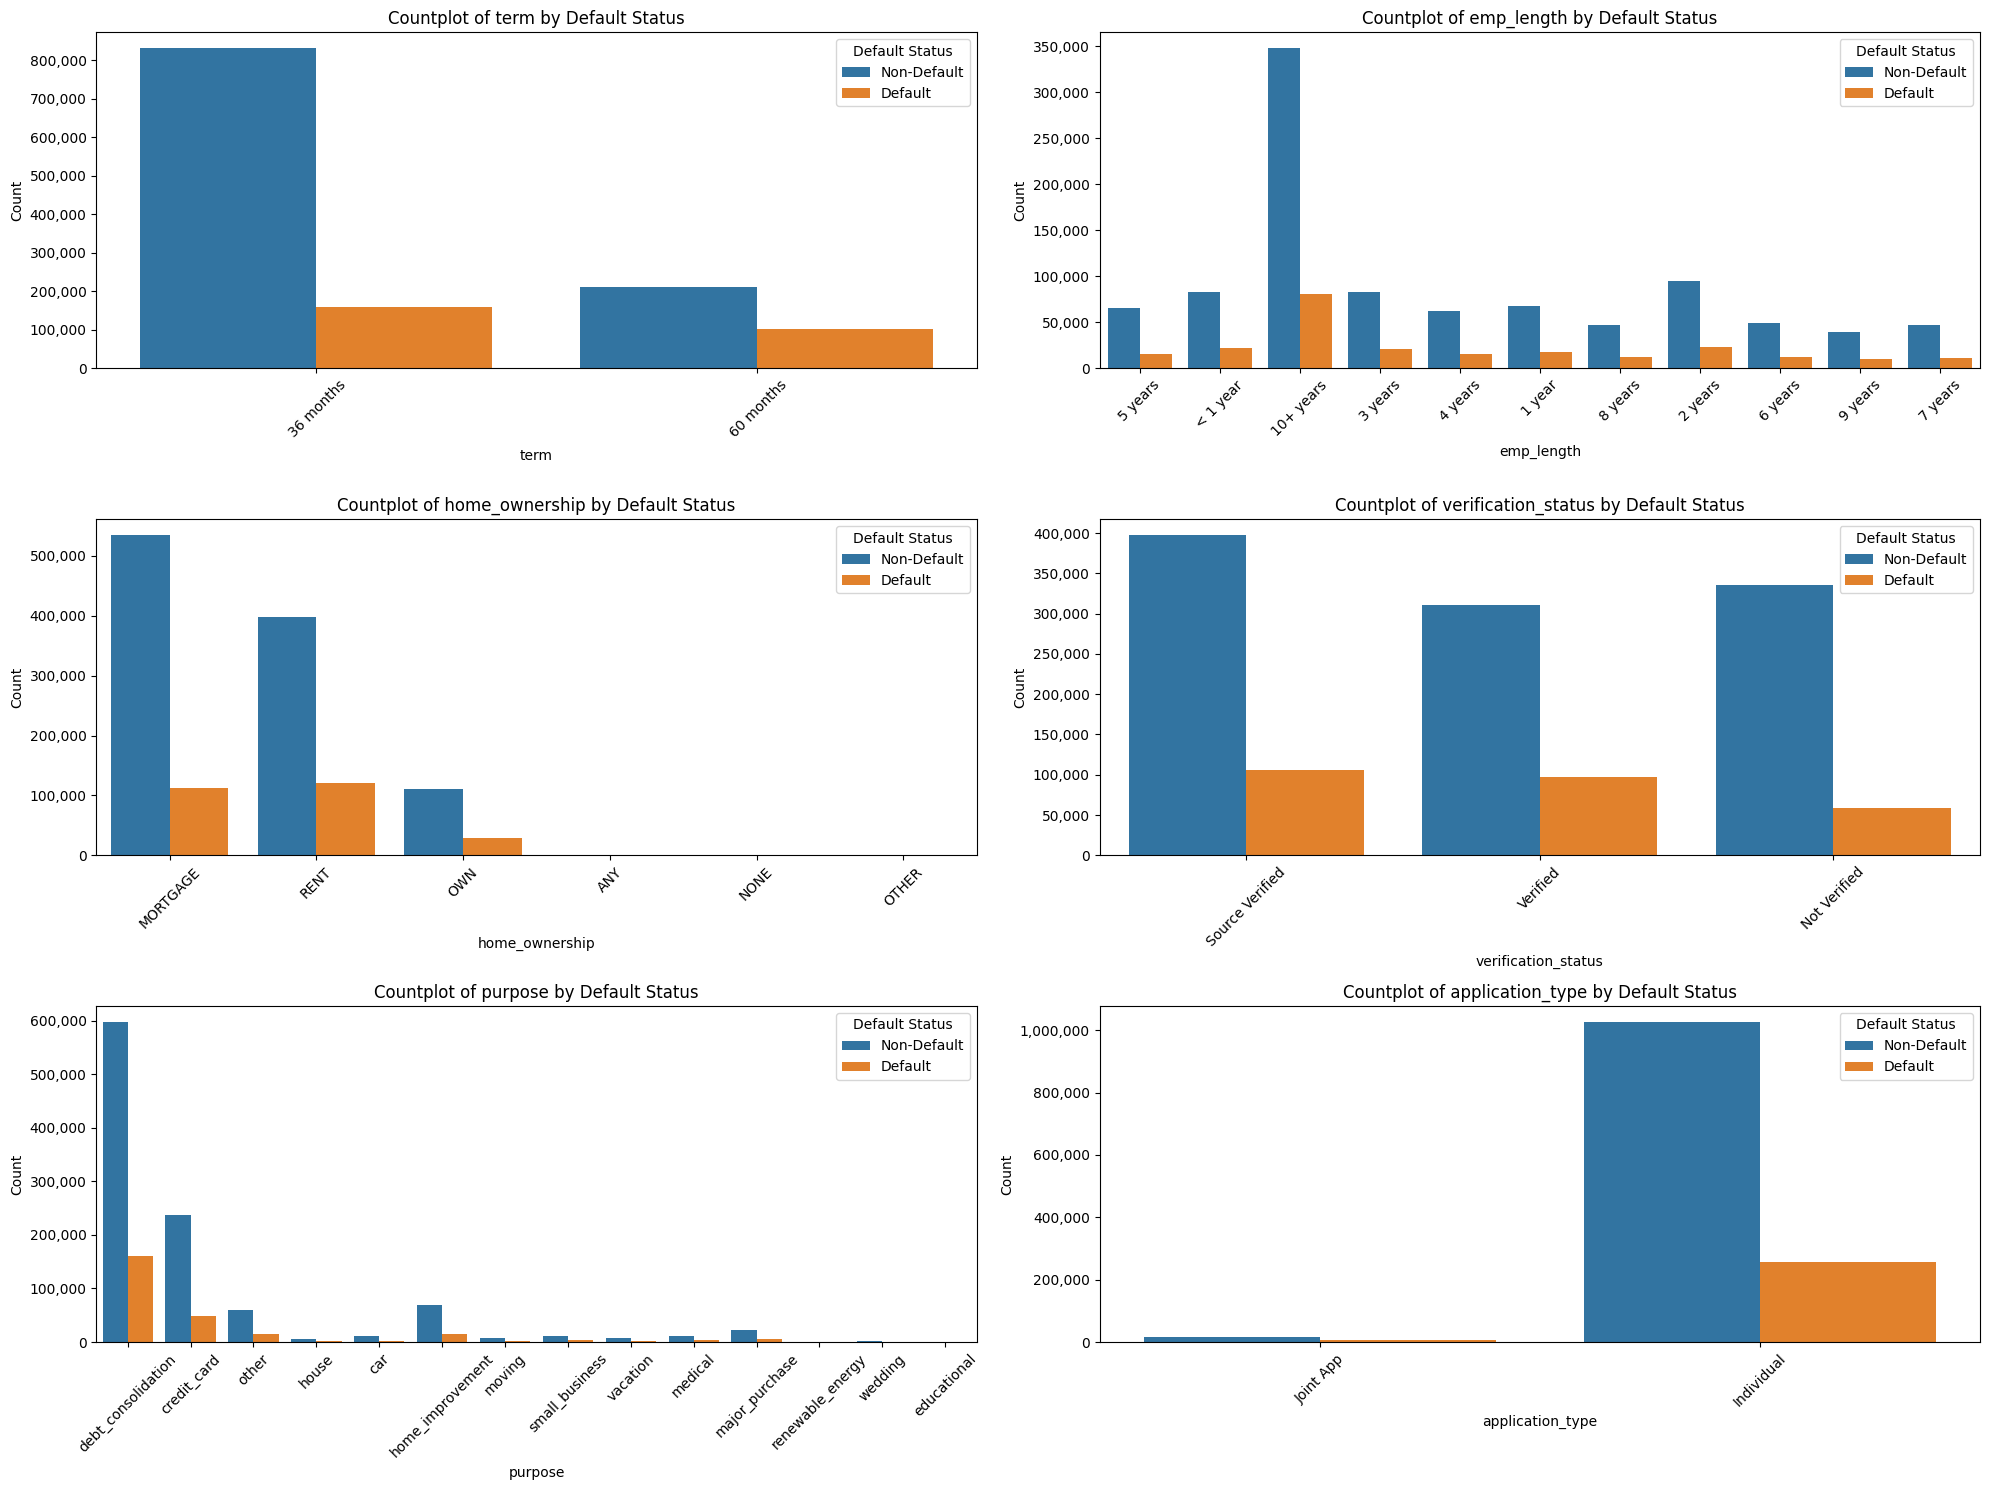

In [66]:
cat_features = loan_set.drop(['earliest_cr_line','loan_status'],axis =1).select_dtypes(include=['object']).columns.tolist()

n = len(cat_features)
cols = 2
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5))
axes = axes.flatten()

for ax,feature in zip(axes, cat_features):
    sns.countplot(x=feature, hue='is_default', data=loan_set, ax=ax)
    ax.set_title(f'Countplot of {feature} by Default Status')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')
    ax.legend(title='Default Status', labels=['Non-Default', 'Default'])
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
    for label in ax.get_xticklabels():
        label.set_rotation(45)

for i in range(len(cat_features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

### Key Inferences from categorical EDA

1. Long Term (`term`)
Longer repayment horizons are associated with higher credit risk due to prolonged exposure and greater uncertainty.

2. Employment Length (`emp_length`)
Employment stability is an important indicator of repayment capacity and credit risk.

3. Home Ownership (`home_ownership`)
Home ownership serves as a proxy for financial stability and asset backing.

4. Income Verification Status (`verification_status`)
Income verification improves underwriting quality and reduces default risk.

5. Loan purpose (`sanity check`)
Loan purpose captures behavioral and risk segmentation beyond borrower-level characteristics.

6. Application Type (`application_type`)
The vast majority of loans are individual applications and joint application are rare.

## 6. Modelling

This section develops predictive models to estimate the probability of loan default using the prepared dataset. A logistic regression model is first implemented as a baseline due to its interpretability and widespread use in credit risk modeling. The dataset exhibits moderate class imbalance, with defaulted loans accounting for approximately 20% of observations. This imbalance is addressed using appropriate evaluation metrics and model settings rather than through aggressive resampling. More flexible machine learning models are later introduced for performance comparison.

### 6.1 Logistic Regression( Base model )
Logistic Regression is a baseline classification model widely used in credit risk modeling because it is interpretable, stable, and regulator-friendly.
It estimates the probability of default (PD) by modeling the log-odds of default as a linear function of borrower and loan characteristics such as income, DTI, interest rate, and loan amount.

In [67]:
# Identify feature set and target variable
loan_set = loan_set.dropna()
x = loan_set.drop(['loan_status','is_default'], axis=1)
y = loan_set['is_default']

# Create training and testing sets 
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

In [68]:
# Create num and cat feature 
num_features = x.select_dtypes(include=['number']).columns
cat_features = x.select_dtypes(include=['object']).columns

# check the total columns
len(num_features) + len(cat_features) == len(x.columns)

True

In [69]:
def evaluate_model_performance(model,x_test,y_test):

    print("Classification Report:")
    y_pred = model.predict(x_test)
    y_proba = model.predict_proba(x_test)[:, 1]
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"KS Statistic: {ks_2samp(y_proba[y_test == 1], y_proba[y_test == 0]).statistic:.4f}")

This function evaluates a trainded classification using key performance metrics. It computes predcted classes and default probabilities, then reports

- **Classification report** - Precision,recall,F1-score for default vs non-default

- **Confustion Matrix** - Breakdown of correct and incorrect classfications
- **ROC-AUC** - Overall ability of the model to rank risky borrowers above safe one
- **KS Statistic**- Maximum sepration between default and non-default score distribution.

In [110]:
# Create a def to plot all the curve together 

def plot_model_performance(y_test,y_proba):

    fig,axes = plt.subplots(2,2,figsize=(16,6))
    axes = axes.flatten()
    # AUC ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    axes[0].plot(fpr,tpr,label=f'AUC = {auc:.4f}')
    axes[0].plot([0,1],[0,1],linestyle='--',label='Random Classifier')
    axes[0].set_title('ROC Curve')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].legend()
    axes[0].grid(True)

    # KS Curve
    df = pd.DataFrame({'y_test': y_test, 'y_proba': y_proba})
    df = df.sort_values(by='y_proba', ascending=False)

    df['cum_bad'] = (df['y_test'] == 1).cumsum() / (df['y_test'] == 1).sum()
    df['cum_good'] = (df['y_test'] == 0).cumsum() / (df['y_test'] == 0).sum()
    df['ks'] = abs(df['cum_bad'] - df['cum_good'])

    ks_value = df['ks'].max()
    df['population'] = np.arange(1,len(df)+1)/len(df)
    axes[1].plot(df['population'],df['cum_bad'], label='Cumulative Bad')
    axes[1].plot(df['population'],df['cum_good'], label='Cumulative Good')
    axes[1].plot(df['population'],df['ks'], '--', label=f'KS = {ks_value:.4f}')
    axes[1].set_title('KS Curve')
    axes[1].set_xlabel('Population Proportion')
    axes[1].set_ylabel('Cumulative Rate')
    axes[1].legend()
    axes[1].grid(True)

    # Lift Cumalative Gain Chart
    df['bin'] = pd.qcut(df['y_proba'], 10, labels=False)
    lift = df.groupby('bin')['y_test'].mean()
    baseline = df['y_test'].mean()

    axes[2].plot(lift.index, lift / baseline, marker='o', label='Lift')
    axes[2].set_title('Lift Chart')
    axes[2].set_xlabel('Decile')
    axes[2].set_ylabel('Lift')  
    axes[2].legend()
    axes[2].grid(True)

    # Thershold sensitivity plot
    thresholds = np.arange(0.05,0.95,0.05)

    precision,recall,approval = [],[],[]
    for t in thresholds:
        y_pred_threshold = (y_proba >= t).astype(int)
        precision.append(precision_score(y_test, y_pred_threshold))
        recall.append(recall_score(y_test, y_pred_threshold))
        approval.append((y_pred_threshold == 0).mean())
    
    axes[3].plot(thresholds, precision, label='Precision')
    axes[3].plot(thresholds, recall, label='Recall')
    axes[3].plot(thresholds, approval, label='Approval Rate')
    axes[3].set_title('Threshold Sensitivity')  
    axes[3].set_xlabel('Threshold')
    axes[3].set_ylabel('Rate')
    axes[3].legend()
    axes[3].grid(True)
    plt.tight_layout()
    plt.show()

This function visualizes multiple credit-risk evaluation metrics in a single view.
It is designed to assess both statistical performance and business usability of a probability-of-default (PD) model.

**1. ROC Curve**\
The ROC curve illustrates the model’s ability to distinguish default from non-default customers across all probability thresholds.

- The diagonal line represents a random classifier (AUC = 0.5).
- The area under the curve (AUC) summarizes overall ranking performance.

**2. KS Curve**\
The KS curve plots the cumulative distribution of defaults and non-defaults after sorting observations by predicted PD.

- The KS statistic is the maximum vertical distance between these two curves.

- It measures how well the model separates risky from safe customers.

**3. Lift Chart — Business Efficiency**\
The lift chart evaluates how much better the model performs compared to random selection by dividing customers into risk deciles.

- Lift > 1 indicates improved default capture over random.
- Higher lift in top deciles means better prioritization of high-risk cases.

**4.Threshold Sensitivity — Policy Trade-offs**\
This plot examines how model decisions change when different PD thresholds are applied.

Metrics shown:

- Recall — proportion of defaults correctly identified.
- Precision — accuracy of default predictions.
- Approval rate — proportion of customers classified as non-default.

In [71]:
# Create preprocessing and modeling pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features)
    ]
)

logit_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42))
])

In [72]:
# fit the model
logit_pipeline.fit(x_train,y_train)

# Make the predictions
y_pred_logit = logit_pipeline.predict(x_test)
y_proba_logit = logit_pipeline.predict_proba(x_test)[:, 1]
# Evaluate model performance
evaluate_model_performance(logit_pipeline,x_test,y_test)


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.66      0.74     36339
           1       0.35      0.63      0.45     10802

    accuracy                           0.65     47141
   macro avg       0.60      0.64      0.60     47141
weighted avg       0.74      0.65      0.68     47141

Confusion Matrix:
[[23830 12509]
 [ 3979  6823]]
ROC AUC Score: 0.6960
KS Statistic: 0.2881


### Key Performance interpretation
**Precision (Default =1) $\approx$ 0.35**
- Many false positives.
- Would reject too many good customers if used directly.

**Recall (Default =1) $\approx$ 0.63**
- The model detects 63% of bad loans.
- it achieves relatively high recall for the baseline model.

**ROC AUC $\approx 0.7$**
- The model reasonably ranks bad loans above good loans.
- Better that random.

**KS $\approx 0.29$**
- KS between 0.2 - 0.40 is acceptable.
- Model provides meaningful separation between cumulative default and non-default distributions.

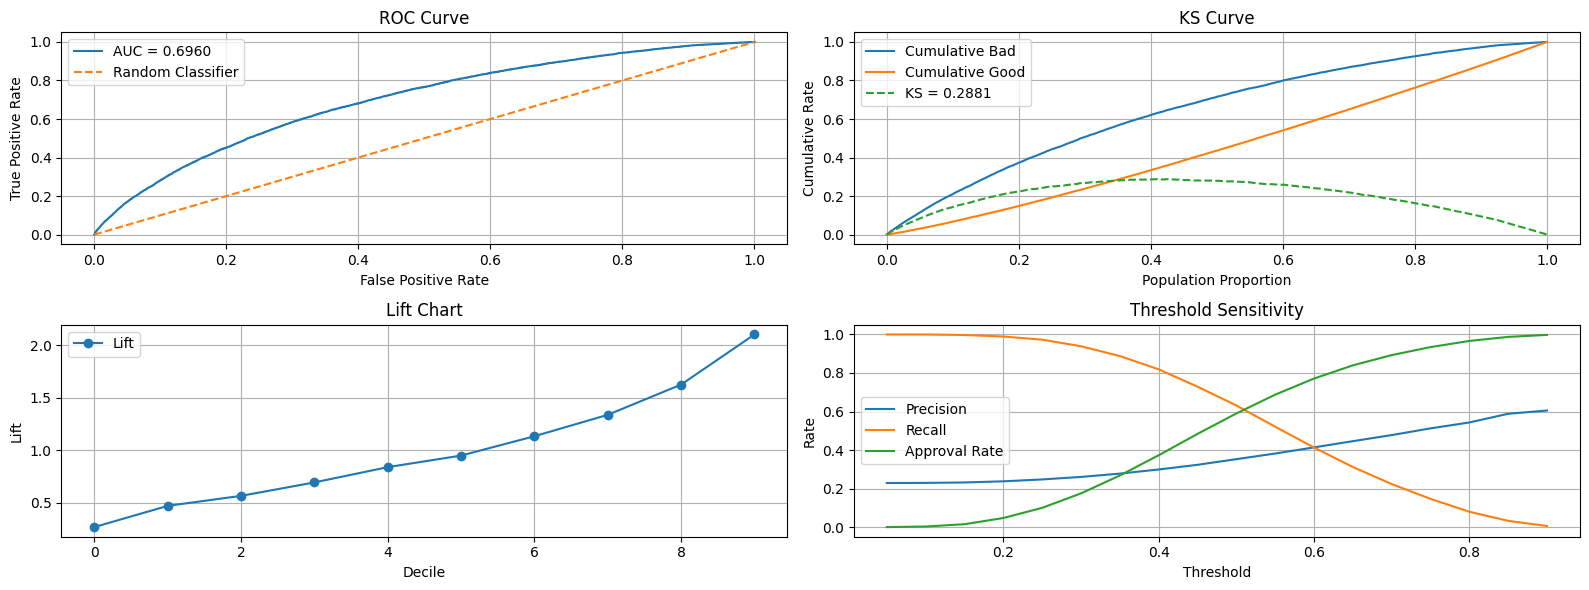

In [111]:
plot_model_performance(y_test,y_proba_logit)  

### Plot Interpretation

**1. ROC Curve**
- Curve clearly above the random line
- The model can rank defaults above non-defaults
- Ranking Quality is acceptablt but not storng

**2. KS Curve**
- KS peaks at about $\approx 0.29$
- Peak occurs around 40-50% of the population
- Meaningful separation between good and bad customers
- Concentration of defaults occurs in the upper risk population

**3. Lift Chart**
- Lift increases steadily across deciles
- Top decilt lit >2
- High-risk segment contain more than twice the average default rate

**4. Threshold Sensitivity**
- Lower threshold $\rightarrow$ high recall, low approval
- Higher threshold $\rightarrow$ higher approval,lower recall
- Model behaves stably and predictably
- No abrupt jumps $\rightarrow$ good calibraition characteristics

Overall, the model demonstrates moderate discriminatory power with an ROC AUC of 0.696 and a KS statistic of 0.288. It effectively ranks higher-risk customers toward the top of the score distribution, making it suitable as a baseline credit-risk model, though further calibration or model enhancement would be required for production decisioning.

### 6.2 XG Boost

XGBoost is introduced as a challenger model to capture non-linear relationships and complex feature interactions that may not be adequately modeled by logistic regression.

In [74]:
# Identify XGBoost model with scale_pos_weight
neg = (y_train==0).sum()
pos = (y_train==1).sum()
xg = XGBClassifier(scale_pos_weight= neg/pos, 
                    eval_metric='logloss', 
                    random_state=42)

# Create the 2nd pipeline with XGBoost
XG_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xg)
])

# fit the model
XG_pipeline.fit(x_train,y_train)

# Make the predictions
y_pred_xg = XG_pipeline.predict(x_test)
y_proba_xg = XG_pipeline.predict_proba(x_test)[:, 1]

# Evaluate model performance
evaluate_model_performance(XG_pipeline,x_test,y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.66      0.74     36339
           1       0.35      0.64      0.45     10802

    accuracy                           0.65     47141
   macro avg       0.61      0.65      0.60     47141
weighted avg       0.74      0.65      0.68     47141

Confusion Matrix:
[[23822 12517]
 [ 3942  6860]]
ROC AUC Score: 0.7015
KS Statistic: 0.2921


### Key Performance interpretation

**1. Precision (default =1): $\approx$0.35**\
Among all cases predicted as default, 35% are actual defaulters. This indicates a relatively high false-positive rate, which may increase the workload for manual review but is common in imbalanced credit-risk datasets.

**2. Recall (default =1) $\approx$ 0.64**\
Model captures 64% of actual defaulters,demonstrating strong sensitivity to credit risk and effective risk capture.

**3. F1-Score $\approx$ 0.45**\
The F1-score summarizes the balance between precision and recall. A value of 0.45 indicates a moderate trade-off, showing that the model prioritizes risk detection while accepting a higher number of false positives.

**4. ROC AUC $\approx$ 0.70**\
ROC AUC measures the model’s overall ranking ability. A value of 0.70 suggests reasonable discrimination between default and non-default borrowers, though the separation is not yet strong.

**5. KS statistic $\approx$ 0.29**\
The KS statistic measures the maximum separation between the cumulative distributions of default and non-default classes. A KS of approximately 0.29 indicates acceptable risk separation, consistent with a baseline credit-risk model.


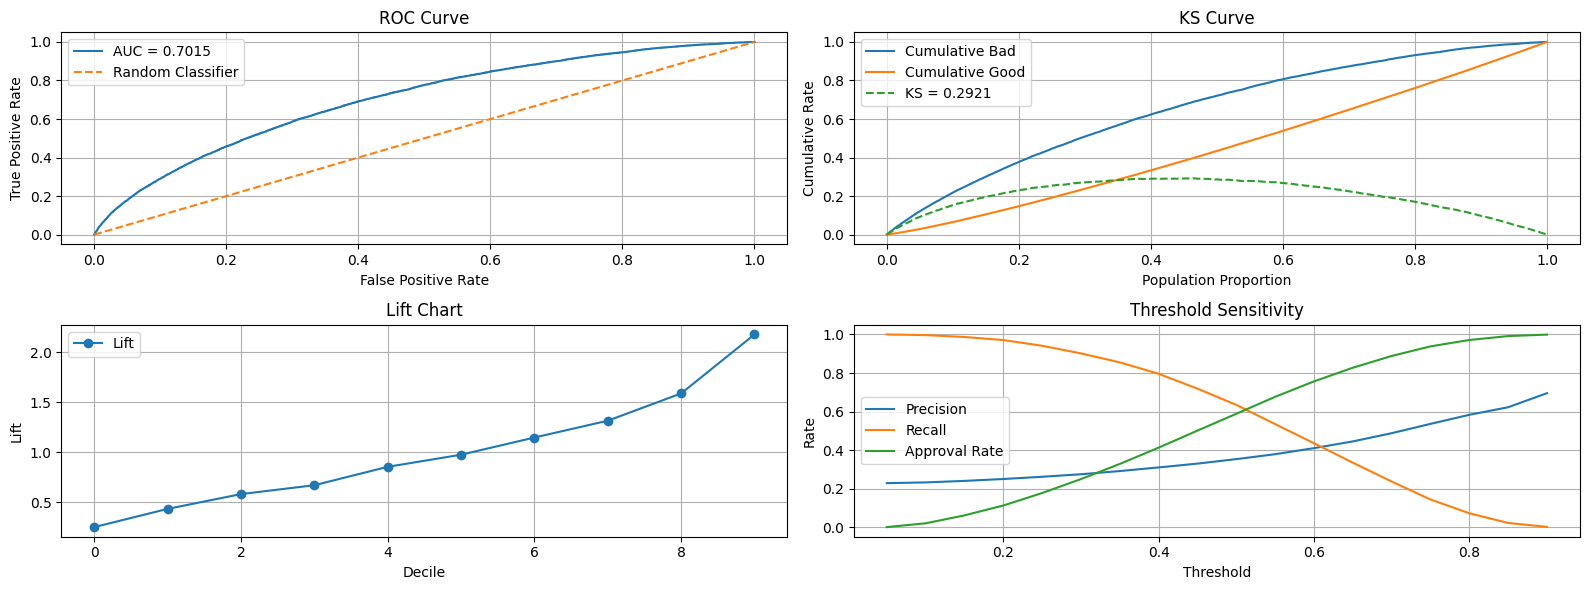

In [112]:
plot_model_performance(y_test,y_proba_xg)

### Plot Interpretation

**1. ROC Curve (Top Left)**
- The model has reasonable ranking power, meaning it can generally assign higer risk score to defaulters thatn to non-defaulters.
- The curve lies consistenly above the random classifier line.

**2. KS Curve (Top-Right)**
- The peak occurs around the middle population proportion.
- A KS close to 0.30 indicates acceptable risk separation.
- The location of the KS peak suggests the model is most informative for mid-risk segments, rather than extreme tails.

**3. Lift Chart (Bottom Left)**
- The top deciles contain significnatly more defaulters than average.
- This confirms the model is effective for prioritizing cases rather than review the full population.

**4. Threshold Sensitivity (Bottom Right)**
- There is a clear trade off between risk capture opertional effieciency.
- Lower thresholds $\rightarrow$ high recall, but many false positives
- Higher thresholds $\rightarrow$ fewer flags, but more missed defaulters.

## Hyperparameter Tunning For XGBoost.

In [109]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    "classifier__max_depth": [3, 5],
    "classifier__learning_rate": [0.05, 0.1],
    "classifier__n_estimators": [200, 400],
    "classifier__subsample": [0.8, 1.0],
    "classifier__colsample_bytree": [0.8, 1.0]
}

# Perform grid search
grid = GridSearchCV(estimator=XG_pipeline,
                    param_grid=param_grid,
                    scoring='roc_auc',
                    cv=3,
                    n_jobs=-1,
                    verbose=1)

# fit the model
grid.fit(x_train, y_train)

# Best parameters from grid search
print("Best parameters found: ", grid.best_params_)
print(f"Best ROC AUC Score from Grid Search: {grid.best_score_:.4f}")
print("\n")

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best parameters found:  {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 5, 'classifier__n_estimators': 400, 'classifier__subsample': 0.8}
Best ROC AUC Score from Grid Search: 0.7084




In [77]:
# Get the best model from grid search
xgb_best_model = grid.best_estimator_

# Make predictions with the best model
y_pred_grid_xgb = xgb_best_model.predict(x_test)
y_proba_grid_xgb = xgb_best_model.predict_proba(x_test)[:, 1]
# Evaluate model performance
evaluate_model_performance(xgb_best_model,x_test,y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.64      0.74     36339
           1       0.36      0.66      0.46     10802

    accuracy                           0.65     47141
   macro avg       0.61      0.65      0.60     47141
weighted avg       0.75      0.65      0.67     47141

Confusion Matrix:
[[23419 12920]
 [ 3686  7116]]
ROC AUC Score: 0.7103
KS Statistic: 0.3047


### Key Performance interpretation

**1. Precision (default = 1) $\approx$ 0.36**
Among all cases predicted as default, 36% are actual defaulters. This indicates a relatively high false-positive rate, which may increase manual review workload but is typical for imbalanced credit-risk datasets.

**2. Recall (default = 1) $\approx$ 0.64**

The model correctly identifies 66% of actual defaulters, demonstrating strong sensitivity to credit risk and effective risk capture.
**3. F1-Score $\approx$ 0.46**\
The F1-score reflects the balance between precision and recall. A value of 0.46 indicates a moderate but effective trade-off, showing that the model prioritizes risk detection while accepting additional false positives.

**4. ROC AUC $\approx$ 0.71**\
The ROC AUC measures the model’s overall ranking ability. A value of 0.71 suggests reasonable discrimination between default and non-default borrowers, with improved ranking performance compared to a baseline model.

**5. KS statistic $\approx$ 0.30**\
The KS statistic measures the maximum separation between the cumulative distributions of default and non-default classes. A KS of approximately 0.30 indicates acceptable to strong risk separation, consistent with a well-performing credit-risk screening model.

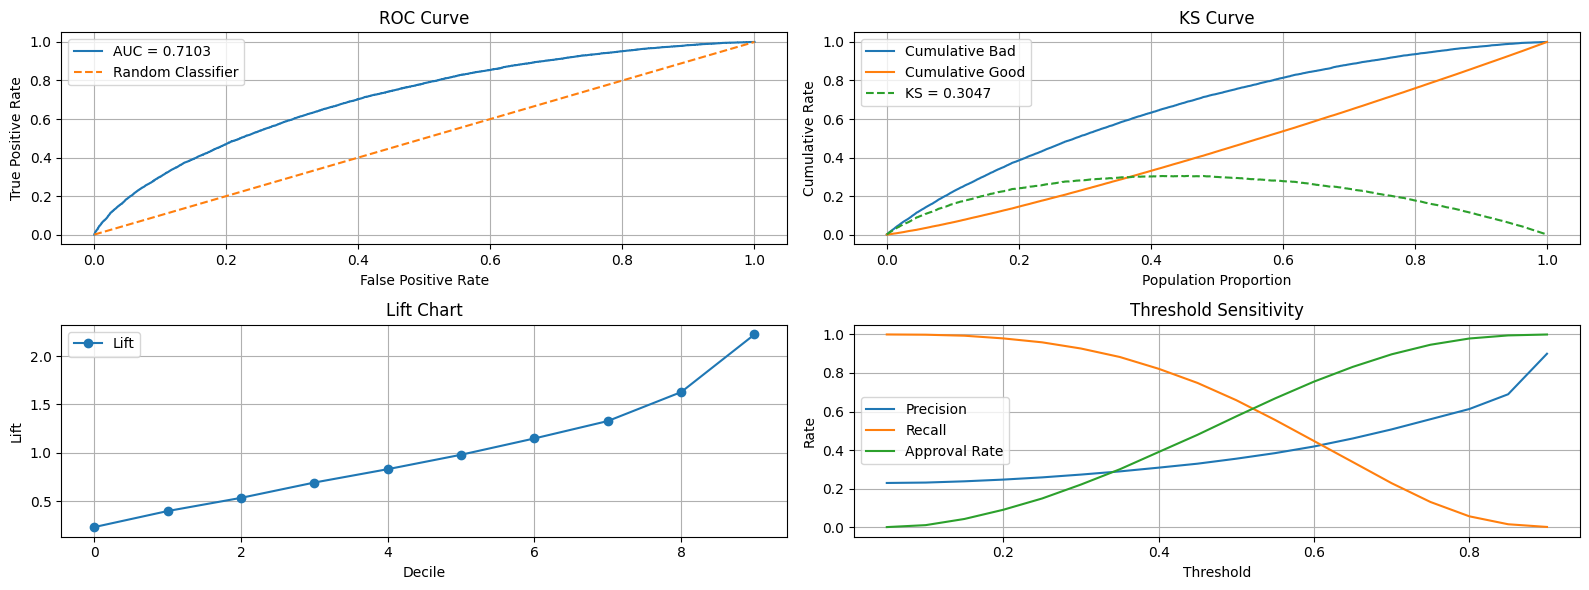

In [113]:
plot_model_performance(y_test,y_proba_grid_xgb)

### Plot Interpretation

**1. ROC Curve (Top Left)**
- The model demonstrates reasonable ranking power, meaning it generally assigns higher risk scores to defaulters than to non-defaulters.
- The ROC curve lies consistently above the random classifier line, indicating meaningful discriminatory ability.

**2. KS Curve (Top-Right)**
- The KS statistic reaches its maximum around the middle of the population distribution.
- A KS value close to 0.30 indicates acceptable risk separation between default and non-default observations.
- he location of the KS peak suggests that the model is most informative for mid-risk segments, rather than concentrating all separation in the extreme tails.

**3. Lift Chart (Bottom Left)**
- The higher-risk deciles contain significantly more defaulters than the population average.
- This confirms that the model is effective for risk-based prioritization, enabling focused review of high-risk cases rather than examining the full population.

**4. Threshold Sensitivity (Bottom Right)**
- The plot illustrates a clear trade-off between risk capture and operational efficiency.
- Lower thresholds $\rightarrow$ high recall, but an increased number of  false positives
- Higher thresholds $\rightarrow$ fewer flags, but a higher number of missed defaulters.

In [79]:
# Get transformed training and testing data
xgb_x_train_trans = xgb_best_model.named_steps['preprocessor'].transform(x_train)
xgb_x_test_trans = xgb_best_model.named_steps['preprocessor'].transform(x_test)

# Get feature names
feature_names = xgb_best_model.named_steps['preprocessor'].get_feature_names_out()
clean_feature_names = [
    re.sub(r'[\[\]<>]', '_', name)
    for name in feature_names
]
# Convert transformed test data to DataFrame
xgb_x_test_trans_df = pd.DataFrame(xgb_x_test_trans.toarray(),columns=clean_feature_names)
xgb_x_test_trans_df.shape

(47141, 708)

2025-12-31 08:25:03,299 - WARNING - From c:\Users\USER\anaconda3\envs\py312\Lib\site-packages\tf_keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.



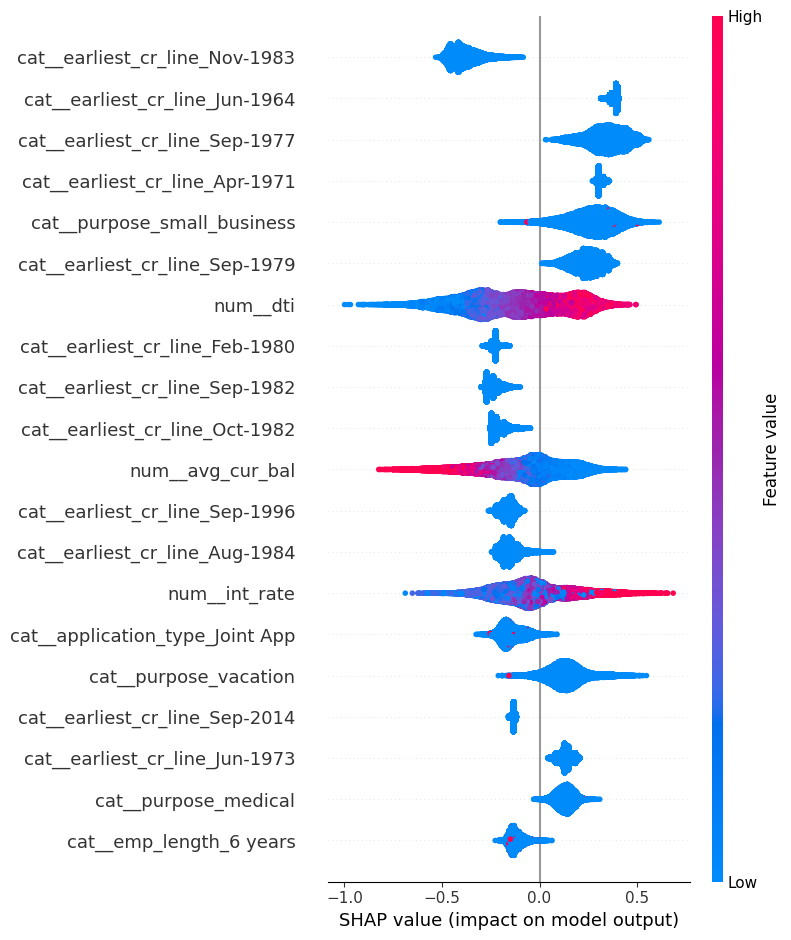

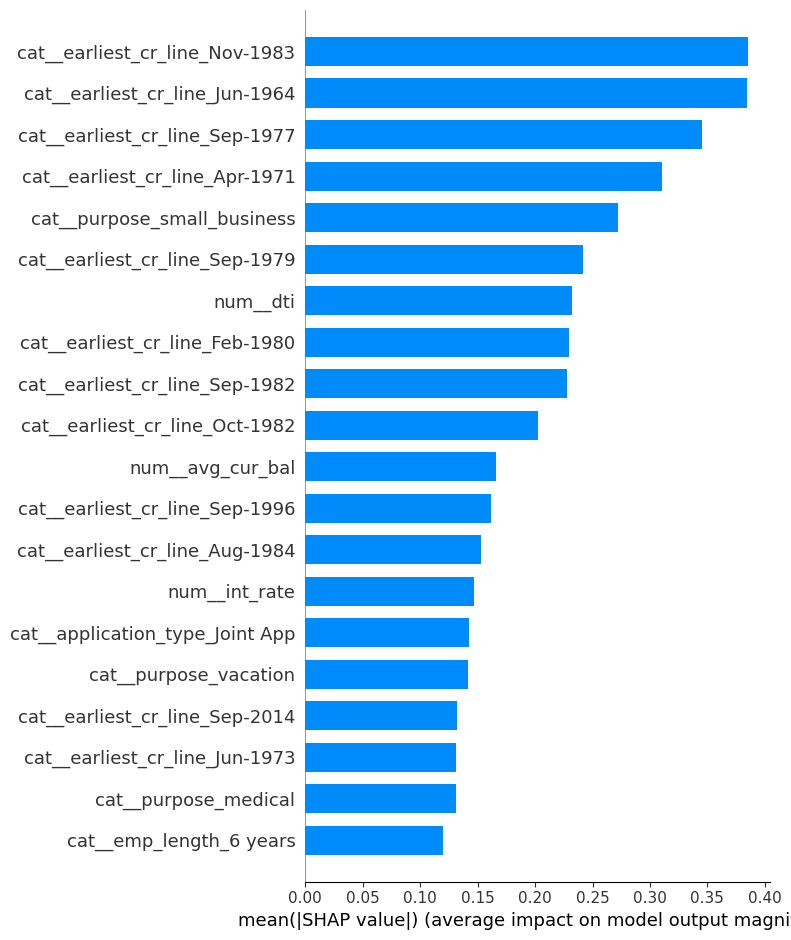

In [80]:
xgb_explainer = shap.TreeExplainer(xgb_best_model.named_steps['classifier'])
xgb_shap_values = xgb_explainer.shap_values(xgb_x_test_trans_df)
shap.summary_plot(xgb_shap_values,xgb_x_test_trans_df)
shap.summary_plot(xgb_shap_values, xgb_x_test_trans_df, plot_type="bar")

### SHAP Summary Interpretation

The Shap bar and beeswarm chart shows which variables have the largest average impact on the model's default prediction across borrowers.

The most inflential drivers of default risk are:

- Credit history start date (`earliest_cr_line`)
Different credit group (e.g., 1964, 1971, 1977, 1983) strongly affect predicted risk.
Older and more established credit histories generally indicate **lower default risk**, while newer credit files are associated with **higher uncertainty and risk**.

- Loan purpose - Small business (`cat_purpose_small_business`)
Small-business loans contribute more to default risk than consumer purposes, reflecting **higher volatility and cash-flow uncertainty**.

- Debt-to-Income-ratio (`num_dti`)
DTI is one of the most important continuous risk driver, indicating higher leverage leads to higer default probability.

- Interest rate (`num_int_rate`)
High interest rates are associated with risk borrowers, making a storng risk signal.

- Average current balance (`num_avg_cur_bal`)
Indicates borrower liquidity and financial buffer.

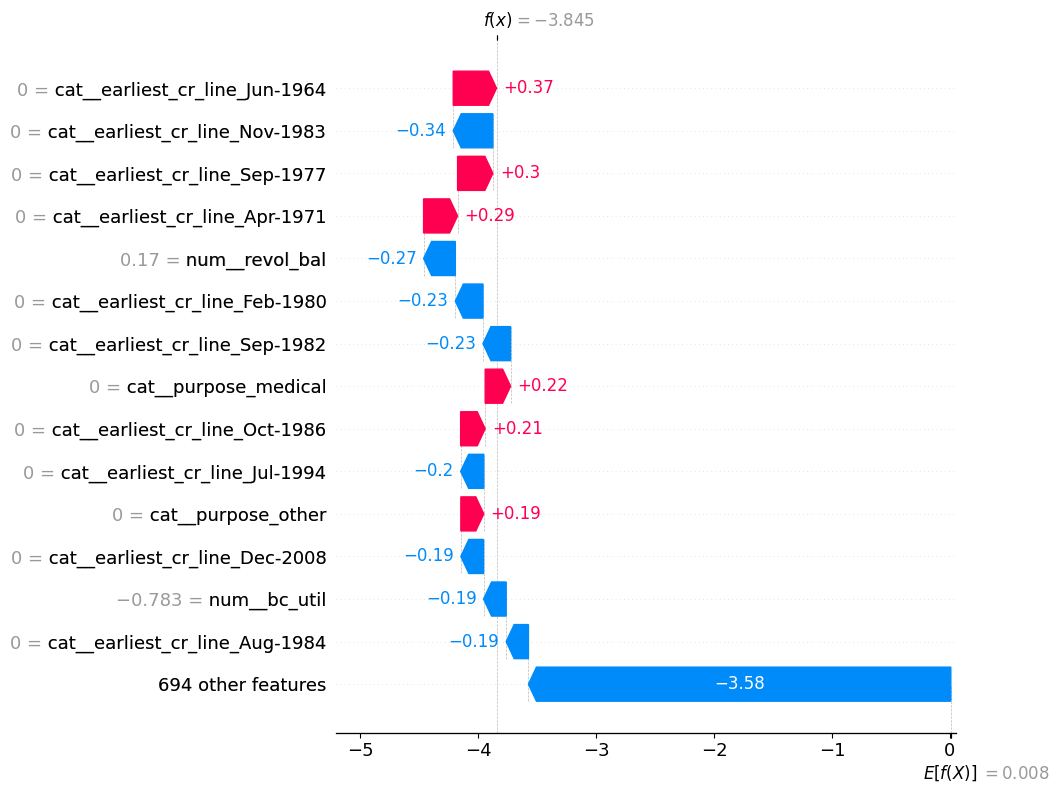

In [81]:
xg_explaination = shap.Explanation(
    values=xgb_shap_values[0],
    base_values=xgb_explainer.expected_value,
    data=xgb_x_test_trans_df.iloc[0],
    feature_names = clean_feature_names)

shap.waterfall_plot(xg_explaination,max_display=15)

###  SHAP Summmary Interpretation (XGBoost)
This waterfall plot explains how individual feature values contribute to the model’s prediction for a single observation, starting from the baseline prediction and moving toward the final model output.

**Baselline and Final Prediction**
- Baseline (E[f(x)]) $\approx$ 0.08 represents the average model output across all observations.
- Final output (f(x)) $\approx$ -3.85 shows that after accounting for all feature. The model assigns a much lower than average risk score to this observation.


### 6.3 LightGBM
LightGBM is tested as an efficient gradient boosting challenger to evaluate whether non-linear modeling can deliver performance comparable to XGBoost with improved computational efficiency.

In [82]:
lightgbm = LGBMClassifier(class_weight='balanced', random_state=42)

pipeline_lgbm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lightgbm)
])

pipeline_lgbm.fit(x_train,y_train)
y_pred_lgbm = pipeline_lgbm.predict(x_test)
y_proba_lgbm = pipeline_lgbm.predict_proba(x_test)[:, 1]
evaluate_model_performance(pipeline_lgbm,x_test,y_test)

[LightGBM] [Info] Number of positive: 43210, number of negative: 145354
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4269
[LightGBM] [Info] Number of data points in the train set: 188564, number of used features: 512
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.64      0.73     36339
           1       0.35      0.67      0.46     10802

    accuracy                           0.64     47141
   macro avg       0.61      0.65      0.60     47141
weighted avg       0.75      0.64      0.67     47141

Confusion Matrix:
[[23098 13241]
 [ 3583  7219]]
ROC AUC Score: 0.7092
KS Statistic: 0.3050

## Result Interpretation

**1. Precision (default =1)  $\approx$ 0.87**\
Among all cases predicted as default, 35% are actual defaulters. This indicates a relatively high false-positive rate, which may increase manual review workload but is common in imbalanced credit-risk datasets.

**2. Recall (default =1) $\approx$ 0.67**\
The model correctly identifies 67% of actual defaulters, demonstrating strong sensitivity to credit risk and effective risk capture.

**3. F1 Score $\approx$ 0.46**\
The F1-score reflects the balance between precision and recall. A value of 0.46 indicates a reasonable trade-off, showing that the model prioritizes risk detection while accepting additional false positives.

**4. ROC AUC $\approx$ 0.71**\
The ROC AUC measures the model’s overall ranking ability. A value of approximately 0.71 suggests reasonable discrimination between default and non-default borrowers, though the separation is not yet strong.

**5. KS Statistic $\approx$ 0.31**\
The KS statistic measures the maximum separation between the cumulative distributions of default and non-default cases. A KS slightly above 0.30 indicates acceptable to strong risk separation, consistent with a well-performing credit-risk screening model.

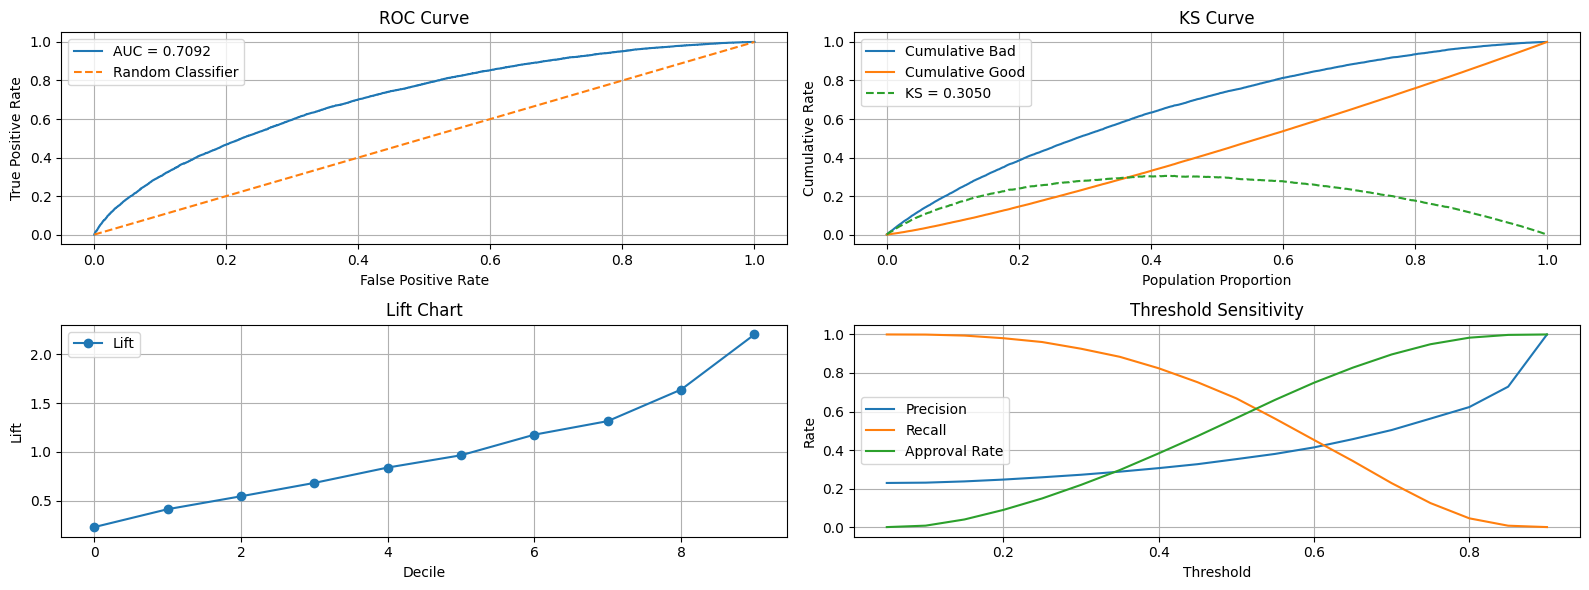

In [114]:
plot_model_performance(y_test,y_proba_lgbm)

In [84]:
param_grid_lgbm = {
    "classifier__num_leaves": [31, 63],
    "classifier__learning_rate": [0.05, 0.1],
    "classifier__n_estimators": [300, 500],
    "classifier__min_child_samples": [20, 50],
    "classifier__subsample": [0.8, 1.0]
}

grid_lgbm = GridSearchCV(estimator=pipeline_lgbm,
                        param_grid=param_grid_lgbm,
                        scoring='roc_auc',
                        cv=3,
                        n_jobs=-1,
                        verbose=1)

grid_lgbm.fit(x_train, y_train)
print("Best parameters found: ", grid_lgbm.best_params_)
print(f"Best ROC AUC Score from Grid Search: {grid_lgbm.best_score_:.4f}")
y_pred_grid_lgbm = grid_lgbm.predict(x_test)
y_proba_grid_lgbm = grid_lgbm.predict_proba(x_test)[:, 1]
evaluate_model_performance(grid_lgbm,x_test,y_test)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[LightGBM] [Info] Number of positive: 43210, number of negative: 145354
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4135
[LightGBM] [Info] Number of data points in the train set: 188564, number of used features: 445
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Best parameters found:  {'classifier__learning_rate': 0.05, 'classifier__min_child_samples': 50, 'classifier__n_estimators': 300, 'classifier__num_leaves': 31, 'classifier__subsample': 0.8}
Best ROC AUC Score from Grid Search: 0.7080
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.64      0.74     36339
           1  

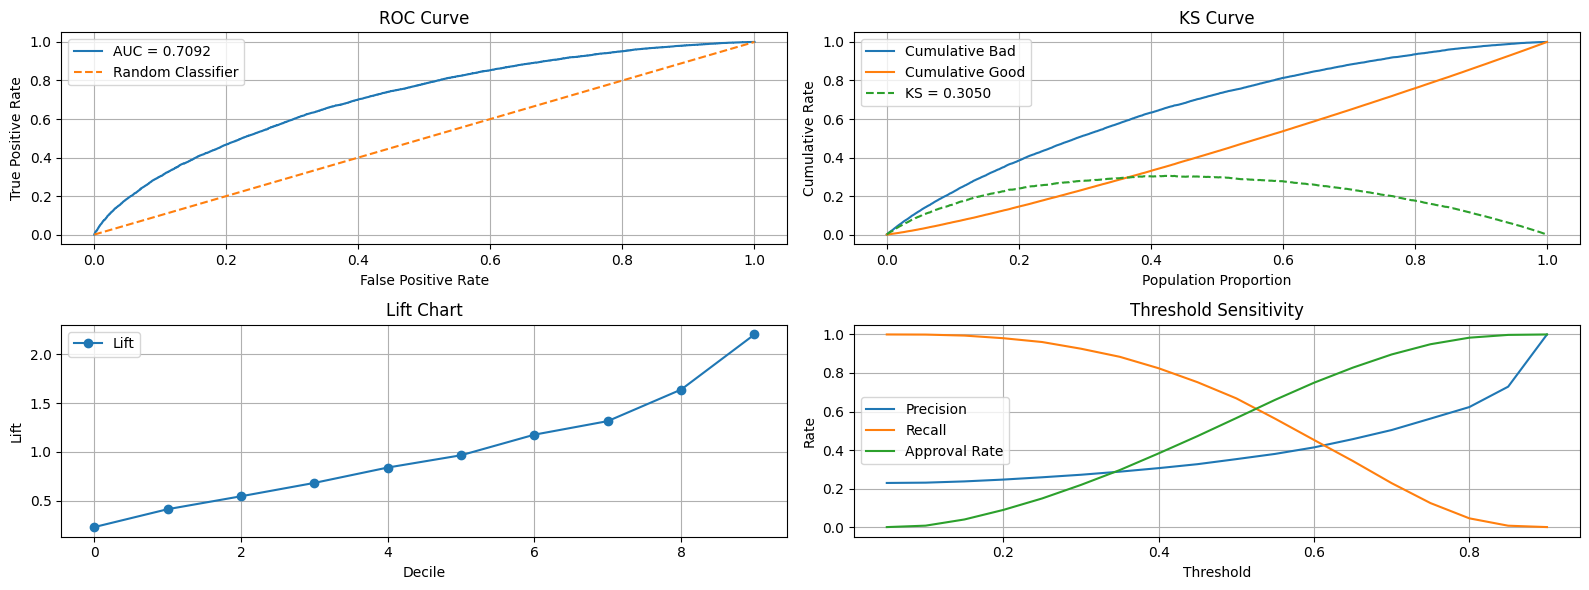

In [115]:
plot_model_performance(y_test,y_proba_lgbm)

## Plot Interpretation

**1. ROC Curve (Top Left)**
- ROC curves lies consistently above the random classifier
- This indicates resonable ranking power, meaning the model generally assins higher risk scores to defaulters.

**2. KS Curver (Top Right)**
- The KS statistic peak at 0.31, suggesting a strong risk separation.
- The peak occurs around the middle of the population, rather tant at the extreame tail.
- This suggests that the model's strongest discriminatory power lies in mid-risk segments.

**3. Lift Chart (Bottom Left)**
- Lift increases steadily across deciles and exceeds 2 in the highest-risk decile.
- This means that the hightest-risk segment contains more than twice the average default rate of the overall population

**4. Threshold Sensitivity (Bottom Right)**
- The plot shows a clear trade-off between risk capture and operational efficiency.
- Lower thresholds $\rightarrow$ higher recall, but more false positives
- Higer thersholds $\rightarrow$ higher precision, but more misssed defaulters.

In [86]:
# shap for lightgbm model
# Get transformed training and testing data
lightgbm_best_model = grid_lgbm.best_estimator_
lightgbm_x_train_trans = lightgbm_best_model.named_steps['preprocessor'].transform(x_train)
lightgbm_x_test_trans = lightgbm_best_model.named_steps['preprocessor'].transform(x_test)

# Get feature names
feature_names = lightgbm_best_model.named_steps['preprocessor'].get_feature_names_out()
clean_feature_names = [
    re.sub(r'[\[\]<>]', '_', name)
    for name in feature_names
]
# Convert transformed test data to DataFrame
lightgbm_x_test_trans_df = pd.DataFrame(lightgbm_x_test_trans.toarray(),columns=clean_feature_names)
lightgbm_x_test_trans_df.shape

(47141, 708)

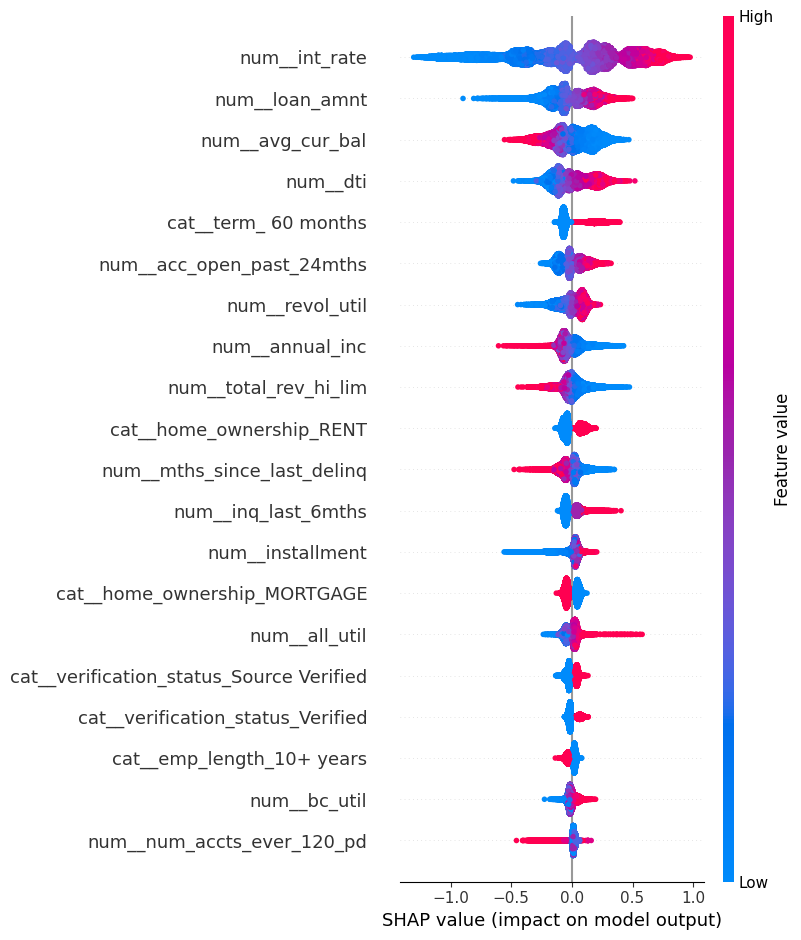

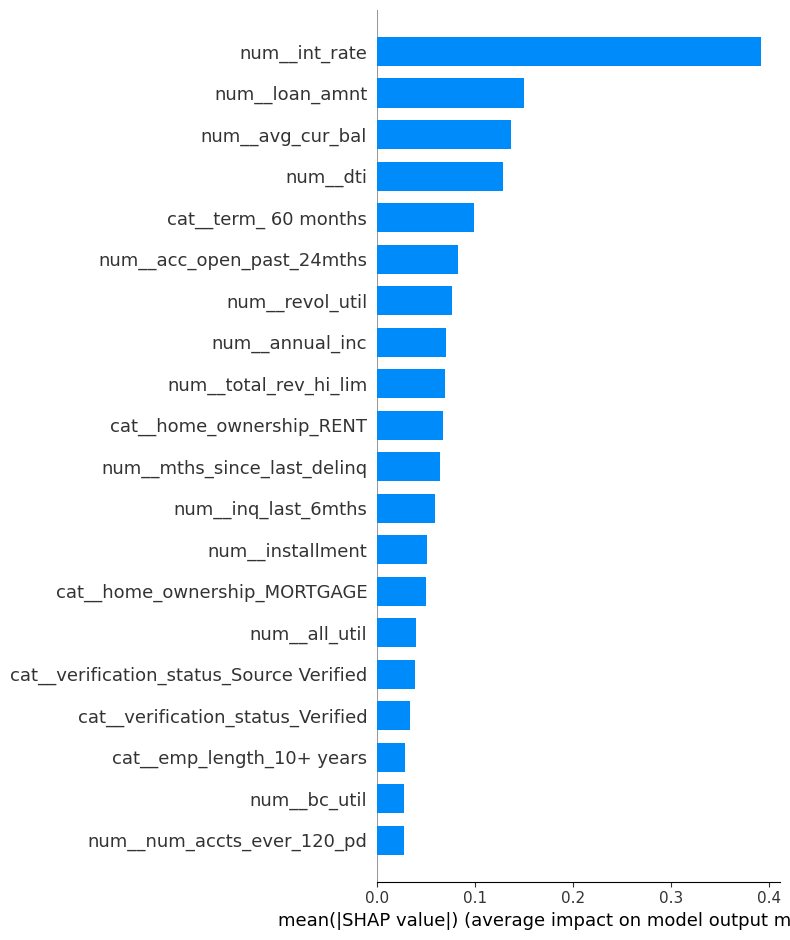

In [87]:
lightgbm_explainer = shap.TreeExplainer(lightgbm_best_model.named_steps['classifier'])
lightgbm_shap_values = lightgbm_explainer.shap_values(lightgbm_x_test_trans_df)
shap.summary_plot(lightgbm_shap_values,lightgbm_x_test_trans_df)
shap.summary_plot(lightgbm_shap_values, lightgbm_x_test_trans_df, plot_type="bar")

## SHAP Summary Interpretation
- Interest rate (`num_int_rate`) is the main driver:\
higer interest rates increase default risk, while lower interest rates reduce it.

- Loan Amount (`num_loan_amnt`):\
larger loand are associated with higer default risk

- Average Current Balance ( `num_avg_cal_bal`):\
Higer current balance can reduct the risk of default.

- Debt-to-income-ration (`num_dti`):\
Higer DTI leads to higer predicted default risk

- Credit utilization (`num__revol_util`, `num__all_util`):
higher utilization increases risk, indicating financial stress.

- Annual income and credit limits:\
higher income and larger credit limits lower default risk.

- Loan structure (e.g., 60-month term, higher installment):\
longer and heavier repayment obligations increase default risk.

- Borrower stability (mortgage ownership, long employment, verified income):\
these features are associated with lower default risk.

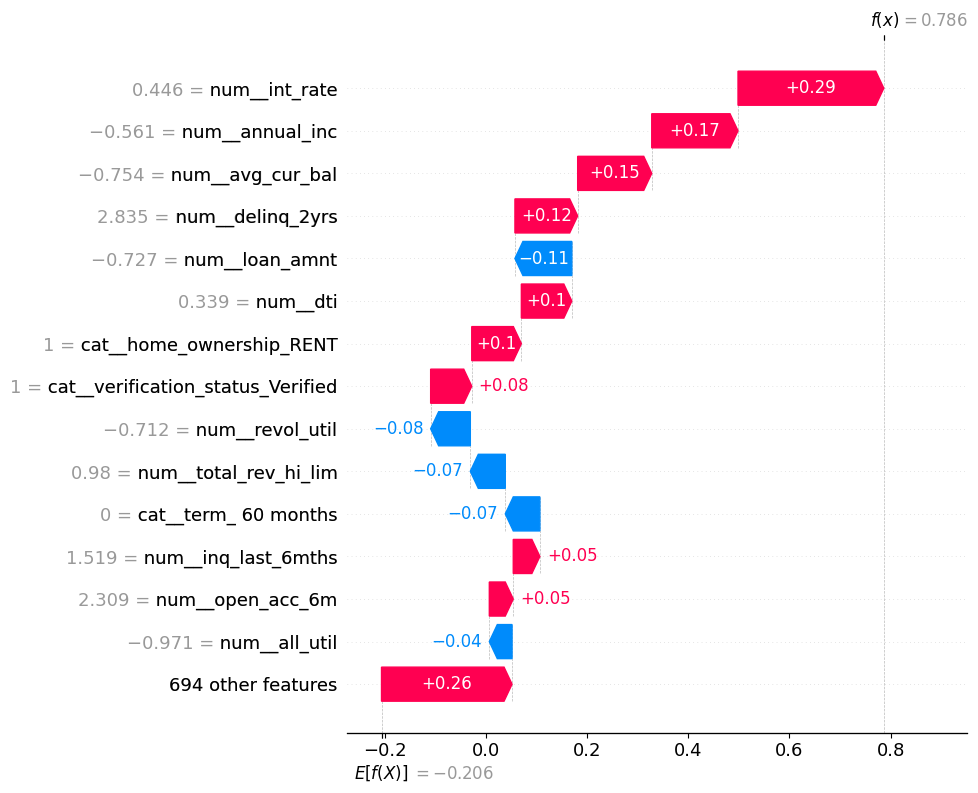

In [88]:
explaination = shap.Explanation(
    values=lightgbm_shap_values[0],
    base_values=lightgbm_explainer.expected_value,
    data=lightgbm_x_test_trans_df.iloc[0],
    feature_names = clean_feature_names)

shap.waterfall_plot(explaination,max_display=15)

In [89]:
# Probability of Default of the peson in the shap waterfall plot
log_odds1 = 0.08
pd1 = 1/(1+np.exp(-log_odds1))

log_odds2 = 1.001
pd2 = 1/(1+np.exp(-log_odds2))

print(f"Probability of Default of average person in this dataset: {pd1:.4f}")
print(f"Probability of Default of the person in the SHAP waterfall plot: {pd2:.4f}")

Probability of Default of average person in this dataset: 0.5200
Probability of Default of the person in the SHAP waterfall plot: 0.7313


### Local SHAP Interpretation

Baseline and Final prediction
- Baseline (E[f(x)]) $\approx$ = 0.008 represents the average model output across all borrowers
- Final model output (f(x)) $\approx$ 1 indicates this borrower is predicted to have a higher-than-average default risk.

**Main Risk-Increasing Factors**
- High interest rate (`num__int_rate`) is the strongest driver, indicating that expensive borrowing significantly increases risk.

- Recent delinquencies (`num__delinq_2yrs`) increase risk, reflecting recent credit problems.

- Higher debt-to-income ratio (`num__dti`) suggests financial stress.

- Renting a home (`cat__home_ownership_RENT`) is associated with less financial stability.

- Recent credit activity (`num__inq_last_6mths`, `num__open_acc_6m`) indicates aggressive borrowing behavior.

**Main Risk Reducing Factors**
- Lower loan amount (`num__loan_amnt`)reduces exposure.

- Lower credit utilization (`um__revol_util`,` num__all_util`) indicates better credit management.

- Higher credit limit (`num__total_rev_hi_lim`) suggests stronger borrowing capacity.

- Shorter loan term (not 60 months) slightly lowers risk.

## 7. Model Performance Comparison

Multiple models were trained and evaulated to identify the best cannidate for credit risk prediction, including Logistic Regression, XGBoost, and LightGBM, also along with the grid search optimized version.

To ensure a fair and compreheansive comparision, both **classification performance** and **ranking power** were assessed

In [90]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'XGBoost','XGBoost (grid)', 'LightGBM','LightGBM (grid)'],
    'Precision':[precision_score(y_test, y_pred_logit),
                precision_score(y_test, y_pred_xg),
                precision_score(y_test, y_pred_grid_xgb),
                precision_score(y_test, y_pred_lgbm),
                precision_score(y_test, y_pred_grid_lgbm)],
    'Recall':[recall_score(y_test, y_pred_logit),
              recall_score(y_test, y_pred_xg),
              recall_score(y_test, y_pred_grid_xgb),
              recall_score(y_test, y_pred_lgbm),
              recall_score(y_test, y_pred_grid_lgbm)],
    'F1-Score':[f1_score(y_test, y_pred_logit),
                f1_score(y_test, y_pred_xg),
                f1_score(y_test, y_pred_grid_xgb),
                f1_score(y_test, y_pred_lgbm),
                f1_score(y_test, y_pred_grid_lgbm)],
    'ROC AUC':[roc_auc_score(y_test, y_proba_logit),
               roc_auc_score(y_test, y_proba_xg),
               roc_auc_score(y_test, y_proba_grid_xgb),
               roc_auc_score(y_test, y_proba_lgbm),
               roc_auc_score(y_test, y_proba_grid_lgbm)],
    'KS Statistic':[ks_2samp(y_proba_logit[y_test == 0], y_proba_logit[y_test == 1]).statistic,
                    ks_2samp(y_proba_xg[y_test == 0], y_proba_xg[y_test == 1]).statistic,
                    ks_2samp(y_proba_grid_xgb[y_test == 0], y_proba_grid_xgb[y_test == 1]).statistic,
                    ks_2samp(y_proba_lgbm[y_test == 0], y_proba_lgbm[y_test == 1]).statistic,
                    ks_2samp(y_proba_grid_lgbm[y_test == 0], y_proba_grid_lgbm[y_test == 1]).statistic]
})

results = results.sort_values(by='ROC AUC', ascending=False).reset_index(drop=True)
results.index = results.index + 1
results

,Model,Precision,Recall,F1-Score,ROC AUC,KS Statistic
1,LightGBM (grid),0.355216,0.663211,0.462641,0.710810,0.306856
2,XGBoost (grid),0.355161,0.658767,0.461509,0.710337,0.304721
3,LightGBM,0.352835,0.668302,0.461839,0.709194,0.304983
4,XGBoost,0.354028,0.635068,0.454621,0.701545,0.292120
5,Logistic Regression,0.352938,0.631642,0.452844,0.695969,0.288132


### Comparision Interpretation
LightGBM with hyperparameter tuning (GridSearch) is the best model.

It achieves the highest AUC (0.711) and KS (0.307), meaning it has the strongest
ability to rank and separate defaulters from non-defaulters.

It also maintains high recall (~66%), so it captures most risky borrowers,
which is crucial for Credit QA and early-warning systems.

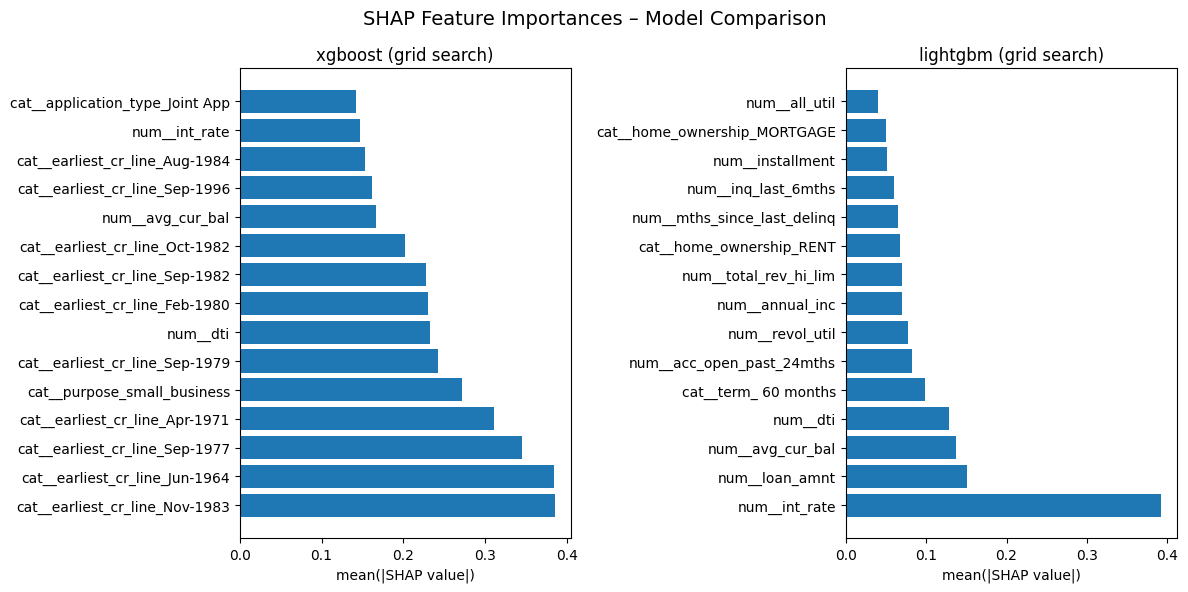

In [91]:
fig,axes = plt.subplots(1,2,figsize=(12,6))

model = {'xgboost (grid search)': (xgb_best_model,xgb_x_test_trans_df),
         'lightgbm (grid search)': (lightgbm_best_model,lightgbm_x_test_trans_df)
         }

for ax, (name, (pipe, X)) in zip(axes, model.items()):

    model = pipe.named_steps['classifier']

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    if isinstance(shap_values, list):
        shap_values = shap_values[1]

    mean_shap = np.abs(shap_values).mean(axis=0)

    idx = np.argsort(mean_shap)[-15:]
    top_features = X.columns[idx]
    top_shap_values = mean_shap[idx]

    ax.barh(top_features, top_shap_values)
    ax.set_title(name)
    ax.set_xlabel("mean(|SHAP value|)")
    ax.invert_yaxis()

plt.suptitle("SHAP Feature Importances – Model Comparison", fontsize=14)
plt.tight_layout()
plt.show()

The SHAP comparison shows that **LightGBM focuses on finanacial stress and pricing risk**, while **XGBoost focuses on borrower segmentation and credit-history structure**. The differences come from how model learn risk. **XGBoost grows tree level by level** , while **LightGBM grows tree by leaf wise**. LightGBM provieds more intuition risk views. Hence, it will be opted as the primary model for credit risk scoring and QA prioritization. XGBoost is retained as a challenger model to monitor borrower profile.

## 8. Model Calibration

After selecting the best-performing model based on discrimination metrics such as AUC, KS, and lift, the next step is **model calibration**.
While discrimination tells us how well the model ranks risky versus safe borrowers, calibration tells us whether the predicted probabilities reflect real-world default risk.

In [92]:
from sklearn.calibration import CalibratedClassifierCV,calibration_curve


calibrated_models = CalibratedClassifierCV(
    estimator= lightgbm_best_model,
    method='isotonic',
    cv=5
)

calibrated_models.fit(x_train,y_train)

[LightGBM] [Info] Number of positive: 34568, number of negative: 116283
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 150851, number of used features: 423
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 34568, number of negative: 116283
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4092
[LightGBM] [Info] Number of data points in the train set: 150851, number of used features: 426
[LightGBM] [In

,estimator,Pipeline(step...sample=0.8))])
,method,'isotonic'
,cv,5
,n_jobs,None
,ensemble,'auto'
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


In [93]:
pd_raw = lightgbm_best_model.predict_proba(x_test)[:, 1]
pd_hat = calibrated_models.predict_proba(x_test)[:, 1]

# evaluation of the calibrated model
result = pd.DataFrame({
    'Model': ['LightGBM (before calibration)', 'LightGBM (after calibration)'],
    'ROC AUC': [roc_auc_score(y_test, pd_raw), roc_auc_score(y_test, pd_hat)],
    'KS Statistic': [ks_2samp(pd_raw[y_test == 1], pd_raw[y_test == 0]).statistic,
                     ks_2samp(pd_hat[y_test == 1], pd_hat[y_test == 0]).statistic]
})
result.index = result.index + 1
result

,Model,ROC AUC,KS Statistic
1,LightGBM (before calibration),0.71081,0.306856
2,LightGBM (after calibration),0.71131,0.306307


## Result Interpretation
After calibrating the LightGBM model, ROC-AUC and KS remained stable at around **0.71** and **0.31**, confirming that probability calibration did not degrade ranking performance. This means the model preserves its discriminatory power while producing reliable default probabilities, making it suitable for downstream risk-based decisioning and QA flagging.

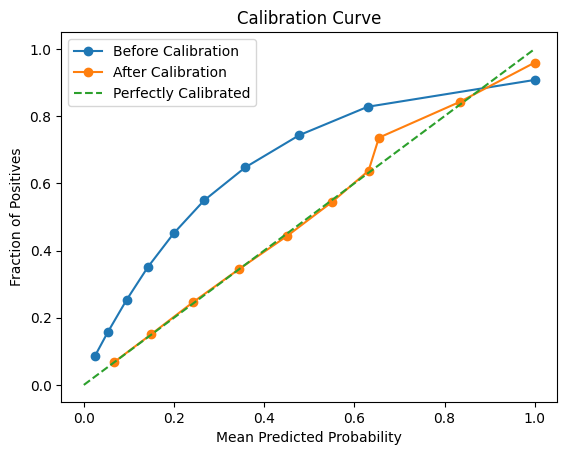

In [94]:
p_raw, pbs_raw = calibration_curve(y_test, pd_raw, n_bins=10)
p_hat, pbs_hat = calibration_curve(y_test, pd_hat, n_bins=10)

plt.plot(p_raw, pbs_raw, marker='o', label='Before Calibration')
plt.plot(p_hat, pbs_hat, marker='o', label='After Calibration')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

## Plot Interpretation (Calibration Curve)
The calibration curve shows that the raw LightGBM model systematically underestimates default risk in the low-to-medium PD range. After isotonic calibration, predicted PDs align closely with observed default rates across all risk buckets, confirming suitability for risk-based decisioning and QA flagging

In [95]:
loan_df = x_test.copy()
loan_df['y_true'] = y_test.values
loan_df['PD'] = pd_hat

loan_df['PD_decile'] = pd.qcut(loan_df['PD'], 10, labels=False) +1

In [96]:
risk_table =loan_df.groupby('PD_decile').agg(
    avg_PD = ('PD','mean'),
    default_rate = ('y_true','mean'),
    defaults = ('y_true','size')).reset_index().sort_values(by='PD_decile', ascending=False)

risk_table.index = risk_table.index +1
risk_table.style.hide(axis='index')

PD_decile,avg_PD,default_rate,defaults
10,0.502239,0.509546,4714
9,0.374096,0.378447,4714
8,0.311351,0.298048,4714
7,0.264325,0.266553,4712
6,0.226442,0.222104,4714
5,0.192296,0.192748,4716
4,0.158633,0.156979,4714
3,0.126745,0.124735,4714
2,0.091899,0.089708,4693
1,0.053385,0.052787,4736


## Result Interpretation

The calibrated LightGBM demostrates strong and consistent risk strartification across PD decille. Borrowers in higer deciles exhibit substantially higer default rate, with Decile 10 showing a **default rate of approximately 51%** compared to only about 5% in Decile 1. Importantly, the average predicted PD closely matches the observed default rate in every decile, indicating that the probability calibration is highly accurate. This confirms that the model not only ranks borrowers effectively by risk

# 9.Risk-Based Decisioning & QA Flagging
After training and validating the credit-risk model, the predicted probability of default (PD) must be translated into actionable credit decisions.

In this section, we implement a decision policy layer that maps model-predicted PDs into operational action bands. This step converts statistical model outputs into a practical credit-quality control framework, enabling scalable automation for low-risk loans while prioritizing high-risk cases for manual review.

The PD thresholds are chosen to illustrate a realistic risk-based decisioning framework and can be adjusted based on business risk appetite, portfolio performance, and QA capacity.

**QA Rules**

Probability of Default >= 0.3 $\rightarrow$ Review or Reject\
Probability of Default >= 0.2 $\rightarrow$ QA\
Probability of Default >= 0.05 $\rightarrow$ Approve with Caution\
Probability of Default < 0.05 $\rightarrow$ Fast-Track Approve

In [97]:
# Define recommended actions based on PD thresholds
loan_df['Action'] = np.select([
    loan_df['PD'] >= 0.3,
    loan_df['PD'] >= 0.2,
    loan_df['PD'] >= 0.05
],[
    'Review/Reject',
    'QA',   
    'Approve with Caution'
],default='Fast-Track Approve')

loan_df.head()

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,pub_rec,revol_bal,revol_util,application_type,acc_now_delinq,open_acc_6m,all_util,total_rev_hi_lim,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_util,num_accts_ever_120_pd,num_tl_op_past_12m,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,y_true,PD,PD_decile,Action
case_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
872890,8000,36 months,15.99,281.22,4 years,RENT,36000.0,Verified,debt_consolidation,21.83,4.0,Aug-1989,2.0,17.0,1.0,18831,30.8,Individual,0.0,4.0,40.0,63600.0,4.0,6.0,1916.0,33.3,1.0,6.0,1.0,0.0,28736.0,1,0.369559,9,Review/Reject
1375060,4000,36 months,8.24,125.79,8 years,RENT,35000.0,Source Verified,debt_consolidation,20.06,0.0,Oct-2006,0.0,74.0,0.0,4593,16.6,Individual,0.0,1.0,39.0,27700.0,2.0,7.0,1621.0,18.3,2.0,4.0,0.0,0.0,19456.0,0,0.144632,4,Approve with Caution
636271,6000,36 months,5.32,180.69,4 years,RENT,64000.0,Not Verified,credit_card,18.66,0.0,Sep-2000,0.0,63.0,0.0,1978,9.7,Individual,0.0,0.0,38.0,20300.0,1.0,4.0,3618.0,8.7,0.0,1.0,0.0,0.0,28946.0,0,0.035030,1,Fast-Track Approve
543288,7200,36 months,11.49,237.40,10+ years,MORTGAGE,43000.0,Verified,home_improvement,18.44,2.0,Aug-2005,0.0,7.0,0.0,115,8.8,Individual,0.0,0.0,61.0,1300.0,0.0,2.0,19873.0,8.8,5.0,0.0,0.0,0.0,4472.0,1,0.157492,4,Approve with Caution
516829,4000,36 months,23.99,156.92,10+ years,RENT,26000.0,Verified,other,17.91,0.0,Jul-2008,0.0,80.0,0.0,870,54.4,Individual,0.0,2.0,92.0,1600.0,2.0,4.0,5707.0,54.4,1.0,2.0,0.0,0.0,17121.0,0,0.390558,9,Review/Reject


In [98]:
summary =loan_df.groupby('Action').agg(
    number_of_loans = ('y_true','count'),
    default_rate = ('y_true','mean'),
).sort_values(by='default_rate', ascending=False)

summary['default_rate'] = summary['default_rate'].apply(lambda x: f"{x:.2%}")

summary

,number_of_loans,default_rate
Action,,
Review/Reject,12792,40.88%
QA,11975,24.26%
Approve with Caution,20447,12.70%
Fast-Track Approve,1927,3.68%


### Result Interpretation

$$Review + QA = 12792+11975 = 24767\ \text{cases}$$
$$Total = 47141 $$
$$\approx 52.53\%\ \text{of protfolio}$$

The calibrated LightGBM model allows the bank to focus QA resources on about 52.53% of applications. The Review/Reject group has a very high default rate (40.88%), indicating strong separation between low- and high-risk borrowers.


# 11. Policy Risk Interpretation by using RAG

In a real banking environment, a credit risk model alone is not sufficient to support QA decisions.
While machine learning can estimate the probability of default and flag high-risk loans, every QA decision must be justified using the bank’s official credit policy and underwriting rules.

This section introduces a Retrieval-Augmented Generation (RAG) framework that connects model-driven risk signals with internal policy documents. The goal is to ensure that each flagged loan is not only identified as risky, but also explained in terms of specific policy breaches, such as DTI limits, income requirements, or loan-to-value thresholds.

In [99]:
# Function to get top n SHAP features for a given row index
def get_top_shap(row_idx,n=5):
    values = lightgbm_shap_values[row_idx]
    feature_names = lightgbm_x_test_trans_df.columns
    features_clean = [f.replace("num__", "").replace("cat__", "") for f in feature_names]

    shap_df = pd.DataFrame({
        'feature': features_clean,
        'shap_value': values
    })

    return shap_df.sort_values(by='shap_value', key=abs, ascending=False).head(n)

In [100]:
# Create qa_cases DataFrame
qa_cases = loan_df[loan_df['Action'].isin(['Review/Reject','QA'])]
qa_cases.index = qa_cases.index.astype(int)

In [101]:
# Get top 5 risk factors from SHAP analaysis for each QA case
top_factors = []
lightgbm_x_test_trans_df.index = x_test.index.astype(int)
for idx in qa_cases.index:
    pos = lightgbm_x_test_trans_df.index.get_loc(idx)
    top = get_top_shap(pos,n=5)
    top_factors.append(",".join(top['feature'].values))

qa_cases['top_risk_factors'] = top_factors

C:\Users\USER\AppData\Local\Temp\ipykernel_12292\3909951085.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qa_cases['top_risk_factors'] = top_factors


In [102]:
# Map segment default rates
# All the numbers are from the part 10
risk_map = {
    'Review/Reject': 0.4088,
    'QA': 0.2426,
    'Approve with Caution': 0.1270,
    'Fast-Track Approve': 0.0212
}
qa_cases['segment_default_rate'] = qa_cases['Action'].map(risk_map)

C:\Users\USER\AppData\Local\Temp\ipykernel_12292\2100132344.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qa_cases['segment_default_rate'] = qa_cases['Action'].map(risk_map)


In [103]:
qa_cases.head()

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,pub_rec,revol_bal,revol_util,application_type,acc_now_delinq,open_acc_6m,all_util,total_rev_hi_lim,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_util,num_accts_ever_120_pd,num_tl_op_past_12m,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,y_true,PD,PD_decile,Action,top_risk_factors,segment_default_rate
case_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
872890,8000,36 months,15.99,281.22,4 years,RENT,36000.0,Verified,debt_consolidation,21.83,4.0,Aug-1989,2.0,17.0,1.0,18831,30.8,Individual,0.0,4.0,40.0,63600.0,4.0,6.0,1916.0,33.3,1.0,6.0,1.0,0.0,28736.0,1,0.369559,9,Review/Reject,"int_rate,annual_inc,avg_cur_bal,delinq_2yrs,loan_amnt",0.4088
516829,4000,36 months,23.99,156.92,10+ years,RENT,26000.0,Verified,other,17.91,0.0,Jul-2008,0.0,80.0,0.0,870,54.4,Individual,0.0,2.0,92.0,1600.0,2.0,4.0,5707.0,54.4,1.0,2.0,0.0,0.0,17121.0,0,0.390558,9,Review/Reject,"int_rate,total_rev_hi_lim,loan_amnt,annual_inc,mths_since_last_delinq",0.4088
1367181,5600,36 months,12.74,187.99,3 years,OWN,60000.0,Source Verified,car,12.24,0.0,Sep-2003,0.0,43.0,0.0,12719,63.6,Individual,0.0,0.0,62.0,20000.0,2.0,3.0,2670.0,98.1,1.0,1.0,0.0,0.0,29369.0,0,0.226424,6,QA,"avg_cur_bal,revol_util,acc_open_past_24mths,loan_amnt,dti",0.2426
758272,20000,36 months,15.31,696.35,10+ years,MORTGAGE,140000.0,Verified,debt_consolidation,26.22,0.0,Nov-1981,0.0,33.0,0.0,35016,65.6,Individual,0.0,2.0,78.0,53400.0,3.0,10.0,25743.0,72.9,4.0,4.0,0.0,0.0,83972.0,1,0.285257,7,QA,"int_rate,dti,loan_amnt,avg_cur_bal,acc_open_past_24mths",0.2426
510803,10000,36 months,12.79,335.93,< 1 year,MORTGAGE,100000.0,Source Verified,home_improvement,12.61,2.0,Sep-1999,2.0,9.0,0.0,3769,26.4,Individual,0.0,0.0,46.0,14300.0,3.0,2.0,7121.0,26.4,1.0,1.0,0.0,0.0,42725.0,0,0.242921,6,QA,"int_rate,delinq_2yrs,emp_length__ 1 year,inq_last_6mths,acc_open_past_24mths",0.2426


In [104]:
# Load policy documents from directory
doc = SimpleDirectoryReader(
    r"C:\Users\USER\Desktop\books\policy",
    required_exts=[".pdf"]
).load_data()

# Configure LlamaIndex settings
Settings.embed_model = OpenAIEmbedding(model="text-embedding-3-small")
Settings.node_parser = SentenceSplitter(chunk_size= 300, chunk_overlap= 50)

# Create vector store index and query engine
index = VectorStoreIndex.from_documents(doc)
query_engine = index.as_query_engine()

2025-12-31 08:29:02,250 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [105]:
# Example query
query = query_engine.query("What is the policy for loan approval and quality assurance?")
print(query)

2025-12-31 08:29:03,540 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-12-31 08:29:04,728 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Loans with a Probability of Default (PD) below 5% are considered low risk and may be automatically approved without manual Quality Assurance (QA) review, as long as no policy exceptions are triggered. For all QA and Review/Reject loans, analysts must document the Model PD, key risk drivers, and policy sections used to justify the decision to ensure auditability, regulatory compliance, and consistent credit decisions. The bank regularly reviews default rates by risk band, model calibration, and QA effectiveness, adjusting PD thresholds and policy rules as needed.


In [106]:
# Generate AI-driven QA report for first 5 cases
results = []

for loan_id, case in qa_cases.head(5).iterrows():
    case = qa_cases.loc[loan_id]

    case_prompt = f"""
    You are a Credit QA analyst.

    Loan ID: {case.name}
    Probability of Default: {case['PD']:.4f}
    Risk Band: {case['Action']}
    Segment Default Rate: {case['segment_default_rate']:.2%}

    Applicant Income: {case['annual_inc']:.2f}
    Debt-to-Income Ratio: {case['dti']:.2f}
    Loan Amount: {case['loan_amnt']:.2f}

    Top Risk Factors: {case['top_risk_factors']}

    Using the bank's credit policy, explain:
    Decision: <Approve or Reject>
    Reason:
    <Explain why this loan falls into this category, referencing policy and risk drivers>
    """
    response = query_engine.query(case_prompt)
    text = str(response)

    # Parse AI output
    try:
        decision = text.split("Decision:")[1].split("Reason:")[0].strip()
        reason = text.split("Reason:")[1].strip()
    except:
        decision = "Unknown"
        reason = text

    results.append({
        "loan_id": loan_id,
        "pd": case["PD"],
        "risk_band": case["Action"],
        "ai_decision": decision,
        "ai_reason": reason
    })

# Create QA report DataFrame
qa_report = pd.DataFrame(results)
pd.set_option("display.max_colwidth", None)
qa_report


2025-12-31 08:29:05,914 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-12-31 08:29:07,261 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-31 08:29:08,805 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-12-31 08:29:10,143 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-31 08:29:10,494 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-12-31 08:29:11,619 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-31 08:29:11,993 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-12-31 08:29:13,208 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-31 08:29:13,573 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-12-31 08

,loan_id,pd,risk_band,ai_decision,ai_reason
0,872890,0.369559,Review/Reject,Reject,"The loan falls into the ""Review/Reject"" category due to the Probability of Default (PD) being 36.96%, which exceeds the threshold of 30% set by the policy. Additionally, the loan amount of 8000.00 exceeds 3 times the verified monthly income of 36000.00. These two factors alone trigger a Quality Assurance review according to the bank's credit policy. Since the loan is in the ""Review/Reject"" category with a PD above 30% and the loan amount exceeding the income threshold, without any strong mitigating factors present such as fully verified high and stable income, significant liquid assets, low existing debt obligations, or a long credit history with no past defaults, the loan must be rejected as per the policy guidelines."
1,516829,0.390558,Review/Reject,Reject,"The loan must be flagged for QA review if the Probability of Default (PD) is greater than or equal to 20%. In this case, the loan's PD is 39.06%, which falls into the Review/Reject category (PD ≥ 30%), indicating a high-risk level. According to the policy, loans in this category should generally be declined unless strong mitigating factors exist. The applicant's income, debt-to-income ratio, and loan amount do not meet the acceptable mitigating factors outlined in the policy. Therefore, based on the bank's credit policy guidelines, this loan should be rejected."
2,1367181,0.226424,QA,Reject,"The loan should be rejected based on the bank's credit policy. The loan falls into the ""QA Review"" category as the Probability of Default (PD) is 22.64%, which exceeds the threshold of 20% requiring a manual QA review. Additionally, the loan amount of 5600.00 exceeds 3 times the verified monthly income of 60000.00, another condition triggering a QA review. Given that the loan is in the ""QA Review"" category and does not meet the acceptable mitigating factors for high-risk lending, it should be rejected according to the policy guidelines."
3,758272,0.285257,QA,Reject,"The loan falls into the ""Review / Reject"" category with a Probability of Default (PD) of 28.53%, exceeding the threshold of 30% for high risk. Additionally, the loan amount of $20,000 exceeds 3 times the verified monthly income of $140,000. According to the credit policy, loans in the ""Review / Reject"" category should generally be declined unless strong mitigating factors are present. In this case, the applicant's Debt-to-Income (DTI) ratio is 26.22%, which is within the acceptable range, but the PD and loan amount criteria are significant risk drivers that warrant rejection."
4,510803,0.242921,QA,Reject,"The loan falls into the ""Review / Reject"" category with a Probability of Default (PD) of 0.2429, which exceeds the threshold of 30% outlined in the policy. Additionally, the loan amount of $10,000 exceeds 3 times the verified monthly income of $100,000. These two factors alone trigger a Quality Assurance (QA) review according to the credit policy guidelines. Since the loan does not meet the acceptable mitigating factors for high-risk lending restrictions, such as fully verified high and stable income, significant liquid assets, low existing debt obligations, or a long credit history with no past defaults, the loan must be rejected as per the policy."


By combining machine-learning risk estimation with RAG-based policy interpretation, the system ensures that high-risk loans are not only detected, but also validated against formal underwriting rules. This significantly reduces the risk of inconsistent QA decisions and improves transparency across portfolios.

## 12. Credit Risk Scoring & Decision Support App (Streamlit)

This section demonstrates how the trained LightGBM Probability of Default (PD) model is deployed into a real-time decision-support application. The app allows users to input loan and borrower information, computes PD using the machine-learning model, maps the PD to a risk band, and provides an automated credit decision and recommendation. This simulates how credit-risk models are used in production systems for pre-screening and quality assurance.

In [107]:
# define a feature for a small model 
feature =  ['annual_inc', 'dti', 'loan_amnt', 'int_rate']
x_lite = loan_set[feature]
y_lite = loan_set['is_default']

# split the data
x_train_lite, x_test_lite, y_train_lite, y_test_lite = train_test_split(
    x_lite, y_lite, test_size=0.2, random_state=42, stratify=y_lite
)

# create a lightgbm model with standard scaler
pipeline_lite = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', LGBMClassifier(  n_estimators=300,
        learning_rate=0.05,
        class_weight='balanced', 
        random_state=42))
])  

pipeline_lite.fit(x_train_lite,y_train_lite)

param_grid = {
    'classifier__n_estimators': [200, 400],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__num_leaves': [15, 31],
    'classifier__max_depth': [3, 5, -1]
}
grid = GridSearchCV(
    pipeline_lite,
    param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(x_train_lite, y_train_lite)
print("Best AUC:", grid.best_score_)
print("Best Params:", grid.best_params_)

[LightGBM] [Info] Number of positive: 43210, number of negative: 145354
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 188564, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[LightGBM] [Info] Number of positive: 43210, number of negative: 145354
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 188564, number of used features: 4
[LightGBM] [Info] [b

In [108]:
best_lite_model = grid.best_estimator_
joblib.dump(best_lite_model, 'lightgbm_best_model.pkl')

['lightgbm_best_model.pkl']